---
# Predictive Business Loan Default Analysis Model
---

**Author**: Dhevina Tailor

**Contact**: [dhevinatailor@gmail.com](mailto:dhevinatailor@gmail.com)

**Date**: November 27, 2023

## Table of Contents
---
1. [Introduction: Data Preprocessing](#introduction)
2. [Loading and Setup](#loadingandsetup)
3. [Data Assessment and Cleaning](#assessment)
4. [Feature Engineering](#feature)
5. [Baseline Modeling](#baseline)
6. [Conclusion](#conclusion)
7. [Saving the Data](#saving)

## Introduction: Data Preprocessing <a class="anchor" id="introduction"></a>
---
Data preprocessing is a crucial step in any data science project. It ensures that the dataset is clean, well-structured, and ready for modeling. This phase involves addressing data quality issues, feature engineering, and preparing the dataset for advanced modeling techniques. The accuracy and reliability of predictive models in financial risk assessment heavily depend on the quality of the input data. Therefore, our preprocessing goals include:

1. **Data Cleaning**: Rectifying issues such as missing values, outliers, and inconsistencies.
2. **Feature Engineering**: Enhancing the dataset with new features or transforming existing ones to improve model performance.
3. **Data Transformation**: Including encoding categorical variables, scaling features, and addressing class imbalances.

By accomplishing these steps, we lay a solid foundation for building robust and accurate predictive models.


## Loading and Setup <a class="anchor" id="loadingandsetup"></a>

### Importing Required Libraries

Before beginning the analysis, it's crucial to import all the necessary libraries. These libraries provide functions and tools that will be used throughout the notebook for various tasks such as data manipulation, visualization, machine learning modeling, and more.

In [85]:
# Importing Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE


In [75]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import OneHotEncoder, StandardScaler 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import time
import pickle
import os
from warnings import filterwarnings
filterwarnings('ignore')

### Get Data

In [2]:
# Load the dataset
df = pd.read_csv("Explored_Loan_Data.csv")

# Display the first few rows of the dataset
df.head()

,Name,City,State,Bank,BankState,NAICS,NoEmp,NewExist,FranchiseCode,UrbanRural,RevLineCr,MIS_Status,SBA_Appv
0,ABC HOBBYCRAFT,EVANSVILLE,IN,FIFTH THIRD BANK,OH,451120,4,2.0,1,0,N,Paid,48000.0
1,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,1ST SOURCE BANK,IN,722410,2,2.0,1,0,N,Paid,32000.0
2,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,GRANT COUNTY STATE BANK,IN,621210,7,1.0,1,0,N,Paid,215250.0
3,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,1ST NATL BK & TR CO OF BROKEN,OK,0,2,1.0,1,0,N,Paid,28000.0
4,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,FLORIDA BUS. DEVEL CORP,FL,0,14,1.0,1,0,N,Paid,229000.0


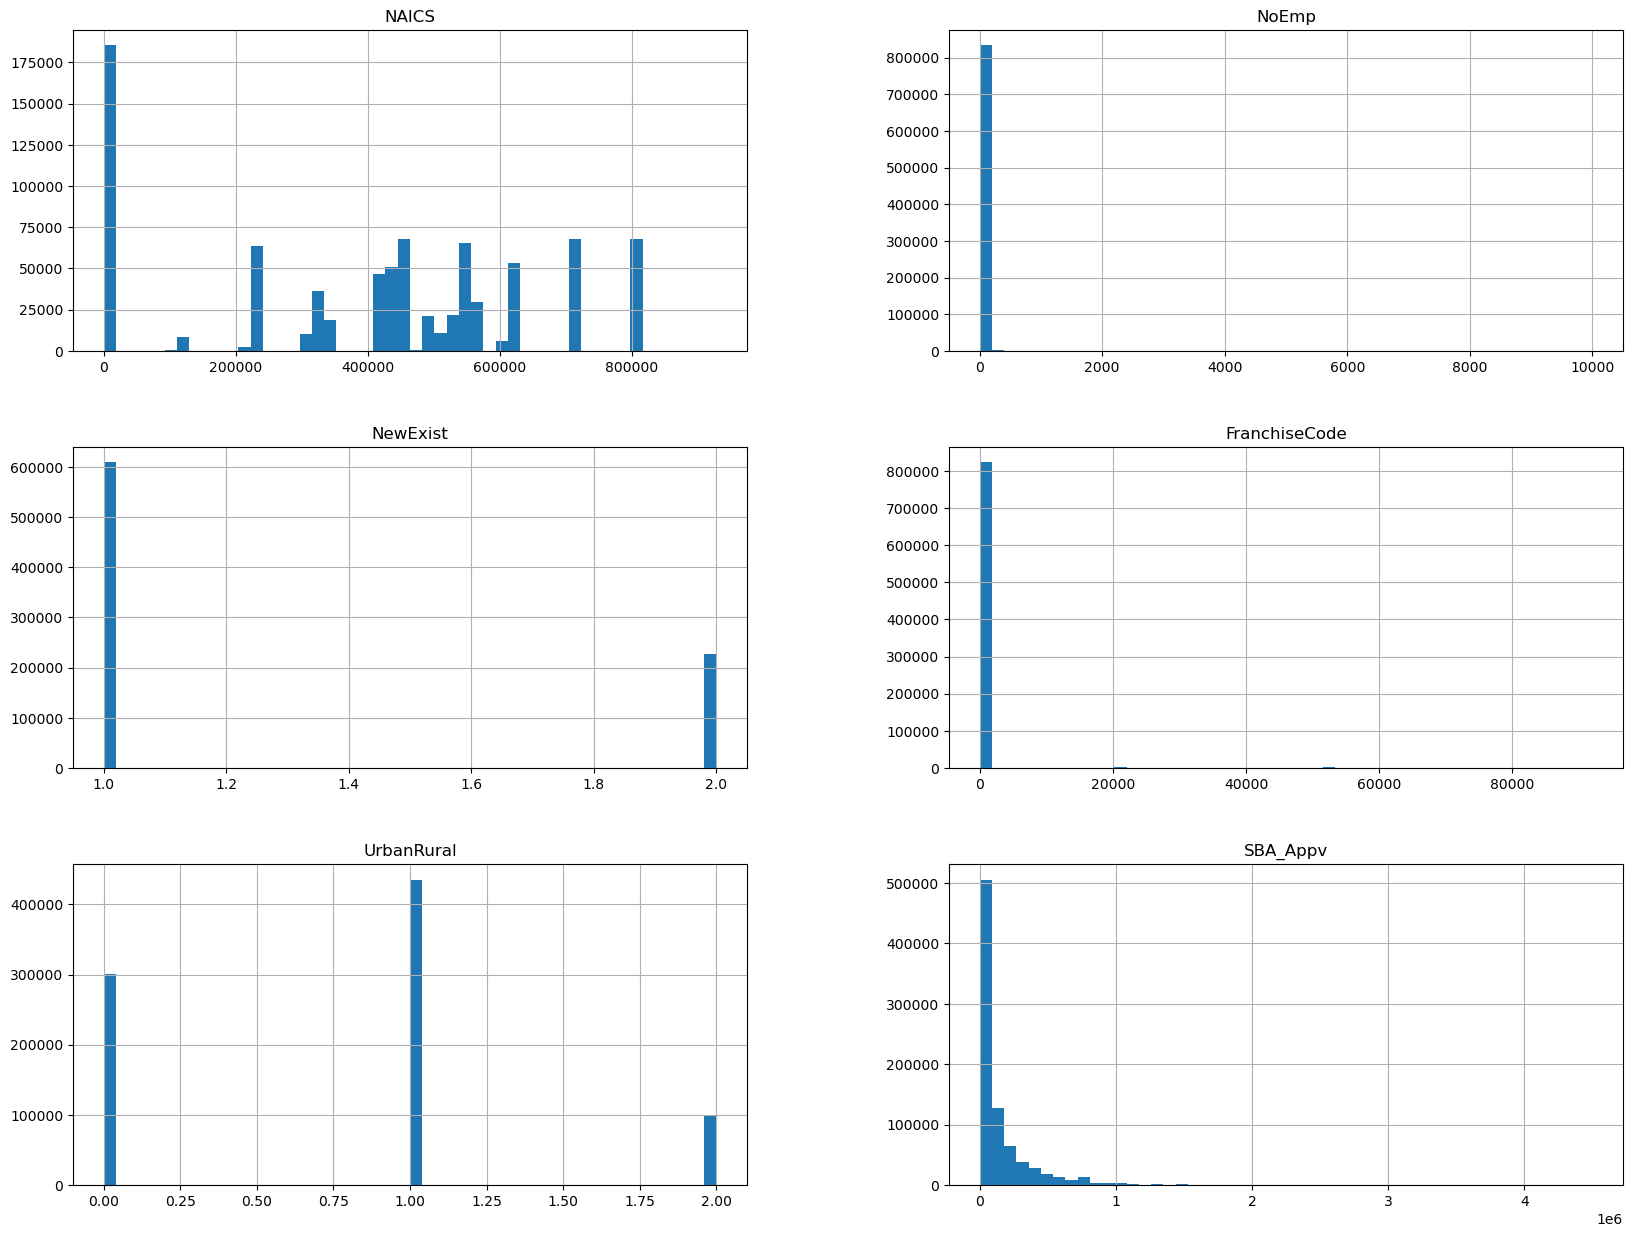

In [3]:
# Visualizing the data distribution
df.hist(bins=50, figsize=(20,15))
plt.show()

We can see that SBA_Appv is skewed to the right. We have addressed the rest in EDA file.

## Data Assessment and Cleaning <a class="anchor" id="assessment"></a>
Our initial assessment focuses on identifying duplicates, irrelevant features, and data inconsistencies. Features like 'City', 'State', and 'Bank' have been dropped due to their high cardinality, which can lead to model overfitting and increased computational complexity. The dataset is then cleaned to remove these columns and any duplicate entries, ensuring data quality and consistency.

In [4]:
def eda_summary(df):
    '''
    Basic EDA function
    '''
    print(f"Rows: {df.shape[0]}")
    print(f"Columns: {df.shape[1]}")
    print(f"Missing values: {df.isna().sum().sum()}")
    print(f"Duplicated rows: {df.duplicated().sum()}")

In [5]:
eda_summary(df)

Rows: 835240
Columns: 13
Missing values: 0
Duplicated rows: 0


Inspecting Categorical columns for unique values prior to creating dummy variables

In [6]:
# Calculate and display the number of unique values in the 'City' column.
unique_values_count = df['City'].nunique()
print(f'Number of unique values in City: {unique_values_count}')

Number of unique values in City: 31734


Will remove the `City` column since it contains an extensive set of 31,734 unique values to avoid potential overfitting.

In [7]:
# Display the number of duplicates before any operations
print(f"Number of duplicates before dropping 'City': {df.duplicated().sum()}")

# Drop the 'City' column
df = df.drop('City', axis=1)

# Check for duplicates after dropping 'City' column
duplicates_after_drop = df[df.duplicated()]

# Display the number of duplicates after dropping 'City'
print(f"Number of duplicates after dropping 'City': {duplicates_after_drop.shape[0]}")

# Display some of the duplicated rows for inspection
print("Sample of duplicated rows:")
print(duplicates_after_drop.head())


Number of duplicates before dropping 'City': 0
Number of duplicates after dropping 'City': 110
Sample of duplicated rows:
                         Name State                       Bank BankState  \
103480                The Kut    AL  BUSINESS LOAN CENTER, LLC        FL   
108351    Aquariumsource, LLC    IL  BUSINESS LOAN CENTER, LLC        FL   
122816  J.L.Y COMPUTERS, INC.    IL   CITIZENS BANK NATL ASSOC        RI   
138924       Kidz Expressions    NC  BUSINESS LOAN CENTER, LLC        FL   
160830             KEYNET INC    NH   CITIZENS BANK NATL ASSOC        NH   

         NAICS  NoEmp  NewExist  FranchiseCode  UrbanRural RevLineCr  \
103480  812112      1       1.0              0           1         N   
108351  454111      1       2.0              0           1         N   
122816  443120      2       1.0              0           1         N   
138924  448130      1       2.0              0           1         N   
160830  541511      2       1.0              1           0   

To mitigate overfitting, I will be removing redundant entries.

In [8]:
# Remove duplicate rows from the DataFrame
df = df.drop_duplicates()

In [9]:
eda_summary(df)

Rows: 835130
Columns: 12
Missing values: 0
Duplicated rows: 0


In [10]:
df.head()

,Name,State,Bank,BankState,NAICS,NoEmp,NewExist,FranchiseCode,UrbanRural,RevLineCr,MIS_Status,SBA_Appv
0,ABC HOBBYCRAFT,IN,FIFTH THIRD BANK,OH,451120,4,2.0,1,0,N,Paid,48000.0
1,LANDMARK BAR & GRILLE (THE),IN,1ST SOURCE BANK,IN,722410,2,2.0,1,0,N,Paid,32000.0
2,"WHITLOCK DDS, TODD M.",IN,GRANT COUNTY STATE BANK,IN,621210,7,1.0,1,0,N,Paid,215250.0
3,"BIG BUCKS PAWN & JEWELRY, LLC",OK,1ST NATL BK & TR CO OF BROKEN,OK,0,2,1.0,1,0,N,Paid,28000.0
4,"ANASTASIA CONFECTIONS, INC.",FL,FLORIDA BUS. DEVEL CORP,FL,0,14,1.0,1,0,N,Paid,229000.0


In [11]:
# Calculate and display the number of unique values in the 'State' column.
unique_values_count = df['State'].nunique()
print(f'Number of unique values in State: {unique_values_count}')

Number of unique values in State: 51


Will remove the `State` column since it contains an extensive set of 51 unique values to avoid potential overfitting.

In [12]:
# Display the number of duplicates before any operations
print(f"Number of duplicates before dropping 'State': {df.duplicated().sum()}")

# Drop the 'State' column
df = df.drop('State', axis=1)

# Check for duplicates after dropping 'State' column
duplicates_after_drop = df[df.duplicated()]

# Display the number of duplicates after dropping 'State'
print(f"Number of duplicates after dropping 'State': {duplicates_after_drop.shape[0]}")

# Display some of the duplicated rows for inspection
print("Sample of duplicated rows:")
print(duplicates_after_drop.head())

Number of duplicates before dropping 'State': 0
Number of duplicates after dropping 'State': 50
Sample of duplicated rows:
                                Name                            Bank  \
69178   HORIZON MEDICAL TECHNOLOGIES      BANK OF AMERICA NATL ASSOC   
124257                 Candy Bouquet       BUSINESS LOAN CENTER, LLC   
157877                   MATCO TOOLS  CITICAPITAL SMALL BUS. FINANCE   
182443                   MATCO TOOLS  CITICAPITAL SMALL BUS. FINANCE   
194738                  MASSAGE ENVY     BANCO POPULAR NORTH AMERICA   

       BankState   NAICS  NoEmp  NewExist  FranchiseCode  UrbanRural  \
69178         WA       0      9       1.0              1           0   
124257        FL  445292      1       2.0              0           1   
157877        TX       0      1       2.0          52000           0   
182443        TX       0      1       2.0          52000           0   
194738        NY  621399      2       2.0          51720           1   

       RevL

To mitigate overfitting, I will be removing redundant entries.

In [13]:
# Remove duplicate rows from the DataFrame
df = df.drop_duplicates()

In [14]:
eda_summary(df)

Rows: 835080
Columns: 11
Missing values: 0
Duplicated rows: 0


In [15]:
df.head()

,Name,Bank,BankState,NAICS,NoEmp,NewExist,FranchiseCode,UrbanRural,RevLineCr,MIS_Status,SBA_Appv
0,ABC HOBBYCRAFT,FIFTH THIRD BANK,OH,451120,4,2.0,1,0,N,Paid,48000.0
1,LANDMARK BAR & GRILLE (THE),1ST SOURCE BANK,IN,722410,2,2.0,1,0,N,Paid,32000.0
2,"WHITLOCK DDS, TODD M.",GRANT COUNTY STATE BANK,IN,621210,7,1.0,1,0,N,Paid,215250.0
3,"BIG BUCKS PAWN & JEWELRY, LLC",1ST NATL BK & TR CO OF BROKEN,OK,0,2,1.0,1,0,N,Paid,28000.0
4,"ANASTASIA CONFECTIONS, INC.",FLORIDA BUS. DEVEL CORP,FL,0,14,1.0,1,0,N,Paid,229000.0


In [16]:
# Calculate and display the number of unique values in the 'Bank' column.
unique_values_count = df['Bank'].nunique()
print(f'Number of unique values in Bank: {unique_values_count}')

Number of unique values in Bank: 5720


Will remove the `Bank` column since it contains an extensive set of 5,720 unique values to avoid potential overfitting.

In [17]:
# Display the number of duplicates before any operations
print(f"Number of duplicates before dropping 'Bank': {df.duplicated().sum()}")

# Drop the 'Bank' column
df = df.drop('Bank', axis=1)

# Check for duplicates after dropping 'Bank' column
duplicates_after_drop = df[df.duplicated()]

# Display the number of duplicates after dropping 'Bank'
print(f"Number of duplicates after dropping 'Bank': {duplicates_after_drop.shape[0]}")

# Display some of the duplicated rows for inspection
print("Sample of duplicated rows:")
print(duplicates_after_drop.head())

Number of duplicates before dropping 'Bank': 0
Number of duplicates after dropping 'Bank': 29
Sample of duplicated rows:
                                  Name BankState   NAICS  NoEmp  NewExist  \
140718     Hometown Sleep Center, Inc.        CA  442110      4       1.0   
149783  AUTHORIZED DISTRIBUTOR MATCO T        TX       0      1       2.0   
149936  AUTHORIZED DISTRIBUTOR MATCO T        TX       0      1       2.0   
194874            VENDING OF TEXAS LLC        CA  454210      2       1.0   
301172                    Balzer, Inc.        WI  333111     79       1.0   

        FranchiseCode  UrbanRural RevLineCr MIS_Status   SBA_Appv  
140718              0           1         Y    Default    25000.0  
149783          52000           0         0    Default    44000.0  
149936          52000           0         0       Paid    44000.0  
194874              1           1         0       Paid     8500.0  
301172              1           2         Y       Paid  1500000.0  


To mitigate overfitting, I will be removing redundant entries.

In [18]:
# Remove duplicate rows from the DataFrame
df = df.drop_duplicates()

In [19]:
eda_summary(df)

Rows: 835051
Columns: 10
Missing values: 0
Duplicated rows: 0


In [20]:
# View updated df
df.head()

,Name,BankState,NAICS,NoEmp,NewExist,FranchiseCode,UrbanRural,RevLineCr,MIS_Status,SBA_Appv
0,ABC HOBBYCRAFT,OH,451120,4,2.0,1,0,N,Paid,48000.0
1,LANDMARK BAR & GRILLE (THE),IN,722410,2,2.0,1,0,N,Paid,32000.0
2,"WHITLOCK DDS, TODD M.",IN,621210,7,1.0,1,0,N,Paid,215250.0
3,"BIG BUCKS PAWN & JEWELRY, LLC",OK,0,2,1.0,1,0,N,Paid,28000.0
4,"ANASTASIA CONFECTIONS, INC.",FL,0,14,1.0,1,0,N,Paid,229000.0


In [21]:
# Calculate and display the number of unique values in the 'BankState'column.
unique_values_count = df['BankState'].nunique()
print(f'Number of unique values in BankState: {unique_values_count}')

Number of unique values in BankState: 56


Will remove the `BankState` column since it contains an extensive set of 56 unique values to avoid potential overfitting.

In [22]:
# Display the number of duplicates before any operations
print(f"Number of duplicates before dropping 'BankState': {df.duplicated().sum()}")

# Drop the 'Bank' column
df = df.drop('BankState', axis=1)

# Check for duplicates after dropping 'BankState' column
duplicates_after_drop = df[df.duplicated()]

# Display the number of duplicates after dropping 'BankState'
print(f"Number of duplicates after dropping 'BankState': {duplicates_after_drop.shape[0]}")

# Display some of the duplicated rows for inspection
print("Sample of duplicated rows:")
print(duplicates_after_drop.head())

Number of duplicates before dropping 'BankState': 0
Number of duplicates after dropping 'BankState': 129
Sample of duplicated rows:
                                 Name   NAICS  NoEmp  NewExist  FranchiseCode  \
8751    Speech Technology Associates,  511210      7       2.0              1   
40183  NORTHEAST BUILDERS & REMODELER  236118      6       1.0              1   
58910             B & B Handbags Inc.  424330      6       1.0              0   
81797                 MINUTEMAN PRESS       0      4       1.0          53650   
89153       Americus Engineering, LC.  541330      1       1.0              0   

       UrbanRural RevLineCr MIS_Status  SBA_Appv  
8751            2         N       Paid   50000.0  
40183           1         N       Paid   25000.0  
58910           1         Y       Paid   25000.0  
81797           0         N       Paid   80000.0  
89153           1         N    Default   21250.0  


To mitigate overfitting, I will be removing redundant entries.

In [23]:
# Remove duplicate rows from the DataFrame
df = df.drop_duplicates()

In [24]:
eda_summary(df)

Rows: 834922
Columns: 9
Missing values: 0
Duplicated rows: 0


In [25]:
# View updated df
df.head()

,Name,NAICS,NoEmp,NewExist,FranchiseCode,UrbanRural,RevLineCr,MIS_Status,SBA_Appv
0,ABC HOBBYCRAFT,451120,4,2.0,1,0,N,Paid,48000.0
1,LANDMARK BAR & GRILLE (THE),722410,2,2.0,1,0,N,Paid,32000.0
2,"WHITLOCK DDS, TODD M.",621210,7,1.0,1,0,N,Paid,215250.0
3,"BIG BUCKS PAWN & JEWELRY, LLC",0,2,1.0,1,0,N,Paid,28000.0
4,"ANASTASIA CONFECTIONS, INC.",0,14,1.0,1,0,N,Paid,229000.0


In [26]:
# Calculate and display the number of unique values in the 'NAICS' column.
unique_values_count = df['NAICS'].nunique()
print(f'Number of unique values in NAICS: {unique_values_count}')

Number of unique values in NAICS: 1311


In [27]:
# View the unique values
unique_values = df['NAICS'].unique()
unique_values

array([451120, 722410, 621210, ..., 315280, 922140, 221121])

We can categorize this according to each industry so we will not drop the `NAICS` column.

In [28]:
# Calculate and display the number of unique values in the 'NoEmp' column.
unique_values_count = df['NoEmp'].nunique()
print(f'Number of unique values in NoEmp: {unique_values_count}')

Number of unique values in NoEmp: 585


In [29]:
# View the unique values
unique_values = df['NoEmp'].unique()
unique_values

array([   4,    2,    7,   14,   19,   45,    1,    3,   24,    5,   16,
         12,    6,   90,   18,    9,   20,   10,    8,   50,   17,   32,
         31,   60,   22,   40,   72,   55,   30,   25,   46,   15,  214,
         28,   23,   11,   13,  112,   26,   42,   65,   21,   97,  100,
        200,  126,   48,   33,   58,   38,   35,    0,   75,   36,   70,
         66,   27, 2000,   56,   34,   93,  150,   29,   41,  290,   67,
         44,   47,  119,   39,  155,   54,   49,   82,   95,  300,   51,
         80,  120,  265,  133,   86,   37,   68,   61,  220,   43,  160,
         71,   98,  350,   78,  233,  263,   62, 7941,   63,  210,  125,
        107,  450,   85,  165,  130, 9992,   77,   64,  424,  257,   52,
        600,  190,  142,   99,   59,   73,  135,   74,  250,   69,  500,
        140,  116,  260,   96,  339,   87,  110,  161,   88,   53,  400,
       2725,  605,   57,  103,   91,   81,  147,  144,  175,  136,  182,
        156,  118,  375,   94,  345,  121,  145,  1

In [30]:
# Calculate and display the number of unique values in the 'NewExist' column.
unique_values_count = df['NewExist'].nunique()
print(f'Number of unique values in NewExist: {unique_values_count}')

Number of unique values in NewExist: 2


In [31]:
# Calculate and display the number of unique values in the 'FranchiseCode' column.
unique_values_count = df['FranchiseCode'].nunique()
print(f'Number of unique values in FranchiseCode: {unique_values_count}')

Number of unique values in FranchiseCode: 719


In [32]:
# View the unique values
unique_values = df['FranchiseCode'].unique()
unique_values

array([    1,     0, 22470, 21425, 21400, 23997, 51570, 81612, 81965,
       23379, 22475, 21420, 23000, 72590, 71456, 44081, 52000, 21780,
       42520, 45455, 81630, 53250, 56480, 62343, 52956, 55120, 61400,
       49952,  4516, 56837, 45479, 33570, 61901, 33550, 62753, 61900,
       21790, 48450, 31150,  9202, 22678, 81602, 55512, 56885, 52018,
       48000, 32074, 55185, 54600, 53165, 45150, 22680, 71658, 21800,
       53657, 33750, 22676, 51720, 55960, 45890, 71685, 11245,  2105,
       56920, 54100, 45505, 53650, 33170, 52707, 81550, 45100, 72515,
       62907, 32077, 81800, 42533, 31243, 45495, 31300, 32195,  5650,
       52875, 32130, 55524, 61401, 55193, 61897, 21660, 48260, 33470,
       42599, 11250, 21870, 44350, 51778, 31415, 52300, 56880, 52855,
        4250, 45955, 44725, 51560,  2357, 56925, 45915, 49855,  9201,
       48400, 62346, 62751, 71158, 81597, 54400, 61390, 62100, 42580,
       55955, 81570, 53680, 72683, 23375, 62760, 61603, 56575,  6140,
       54005, 32125,

Will remove the `FranchiseCode` column since it contains an extensive set of 719 unique values to avoid potential overfitting.

In [33]:
# Display the number of duplicates before any operations
print(f"Number of duplicates before dropping 'FranchiseCode': {df.duplicated().sum()}")

# Drop the 'FranchiseCode' column
df = df.drop('FranchiseCode', axis=1)

# Check for duplicates after dropping 'FranchiseCode' column
duplicates_after_drop = df[df.duplicated()]

# Display the number of duplicates after dropping 'FranchiseCode'
print(f"Number of duplicates after dropping 'FranchiseCode': {duplicates_after_drop.shape[0]}")

# Display some of the duplicated rows for inspection
print("Sample of duplicated rows:")
print(duplicates_after_drop.head())

Number of duplicates before dropping 'FranchiseCode': 0
Number of duplicates after dropping 'FranchiseCode': 46
Sample of duplicated rows:
                                 Name   NAICS  NoEmp  NewExist  UrbanRural  \
43108             DOLLY MADISON, INC.  722110     15       1.0           2   
51197  Severy Brothers Property Manag  812990      2       1.0           2   
58493     SAMME AUTOMOTIVE GROUP, LLC  811111     10       1.0           1   
69056                     MERRY MAIDS       0      1       2.0           0   
75603   TAXATION WITH REPRESENTATION,  541219      1       2.0           1   

      RevLineCr MIS_Status  SBA_Appv  
43108         N       Paid   22500.0  
51197         N       Paid    3250.0  
58493         Y    Default   12500.0  
69056         0       Paid    7750.0  
75603         N    Default   12750.0  


To mitigate overfitting, I will be removing redundant entries.

In [34]:
# Remove duplicate rows from the DataFrame
df = df.drop_duplicates()

In [35]:
eda_summary(df)

Rows: 834876
Columns: 8
Missing values: 0
Duplicated rows: 0


In [36]:
# View updated df
df.head()

,Name,NAICS,NoEmp,NewExist,UrbanRural,RevLineCr,MIS_Status,SBA_Appv
0,ABC HOBBYCRAFT,451120,4,2.0,0,N,Paid,48000.0
1,LANDMARK BAR & GRILLE (THE),722410,2,2.0,0,N,Paid,32000.0
2,"WHITLOCK DDS, TODD M.",621210,7,1.0,0,N,Paid,215250.0
3,"BIG BUCKS PAWN & JEWELRY, LLC",0,2,1.0,0,N,Paid,28000.0
4,"ANASTASIA CONFECTIONS, INC.",0,14,1.0,0,N,Paid,229000.0


In [37]:
# Calculate and display the number of unique values in the 'UrbanRural' column.
unique_values_count = df['UrbanRural'].nunique()
print(f'Number of unique values in UrbanRural: {unique_values_count}')

Number of unique values in UrbanRural: 3


In [38]:
# View the unique values
unique_values = df['UrbanRural'].unique()
unique_values

array([0, 1, 2])

In [39]:
# Calculate and display the number of unique values in the 'RevLineCr' column.
unique_values_count = df['RevLineCr'].nunique()
print(f'Number of unique values in RevLineCr: {unique_values_count}')

Number of unique values in RevLineCr: 3


In [40]:
# View the unique values
unique_values = df['RevLineCr'].unique()
unique_values

array(['N', '0', 'Y'], dtype=object)

In [41]:
# Calculate and display the number of unique values in the 'MIS_Status' column.
unique_values_count = df['MIS_Status'].nunique()
print(f'Number of unique values in MIS_Status: {unique_values_count}')

Number of unique values in MIS_Status: 2


In [42]:
eda_summary(df)

Rows: 834876
Columns: 8
Missing values: 0
Duplicated rows: 0


In [43]:
# Calculate and display the number of unique values in the 'FranchiseCode' column.
unique_values_count = df['Name'].nunique()
print(f'Number of unique values in Name: {unique_values_count}')

Number of unique values in Name: 741337


Will remove the `Name` column since it contains an extensive set of 741,337 unique values to avoid potential overfitting.

In [44]:
# Display the number of duplicates before any operations
print(f"Number of duplicates before dropping 'Name': {df.duplicated().sum()}")

# Drop the 'Name' column
df = df.drop('Name', axis=1)

# Check for duplicates after dropping 'Name' column
duplicates_after_drop = df[df.duplicated()]

# Display the number of duplicates after dropping 'Name'
print(f"Number of duplicates after dropping 'Name': {duplicates_after_drop.shape[0]}")

# Display some of the duplicated rows for inspection
print("Sample of duplicated rows:")
print(duplicates_after_drop.head())

Number of duplicates before dropping 'Name': 0
Number of duplicates after dropping 'Name': 213811
Sample of duplicated rows:
     NAICS  NoEmp  NewExist  UrbanRural RevLineCr MIS_Status  SBA_Appv
84       0      4       1.0           0         0       Paid   12500.0
86       0      3       1.0           0         0       Paid   12500.0
96       0      5       1.0           0         0       Paid   30000.0
97       0      3       1.0           0         0       Paid    5000.0
118      0      3       1.0           0         0       Paid    5000.0


In [45]:
# Remove duplicate rows from the DataFrame
df = df.drop_duplicates()

### Dropping Duplicates in the Dataset

In the provided dataset snippet, it appears that rows are duplicated, with identical values across various columns, particularly in the industry-specific dummy variables. It seems that businesses from the same industry result in the same dataset entries. Given this pattern, there are valid reasons to drop these duplicates:

1. **Redundancy:** The duplicated rows provide redundant information, as the values in all columns are identical except for the "NoEmp" column. Keeping them doesn't add any new insights or contribute to the analysis.

2. **Data Efficiency:** Removing duplicates improves data efficiency by reducing the dataset size without sacrificing information. This is particularly valuable when working with large datasets.

3. **Model Performance:** Duplicates may lead to biased model training and evaluation, as the model could give undue importance to repeated patterns. Removing duplicates helps ensure a fair representation of the data.

4. **Data Consistency:** Keeping duplicates may introduce inconsistencies, especially if future data updates include modifications to only one instance of a duplicate. Removing duplicates maintains data consistency.

5. **Industry-specific Duplicates:** The observed pattern, where businesses from the same industry have identical values, further reinforces the rationale for dropping duplicates. It appears that businesses from the same industry result in the same dataset entries.

Therefore, dropping these duplicates can enhance the quality, efficiency, and reliability of the dataset for further analysis or modeling purposes.


In [46]:
eda_summary(df)

Rows: 621065
Columns: 7
Missing values: 0
Duplicated rows: 0


In [47]:
df.head()

,NAICS,NoEmp,NewExist,UrbanRural,RevLineCr,MIS_Status,SBA_Appv
0,451120,4,2.0,0,N,Paid,48000.0
1,722410,2,2.0,0,N,Paid,32000.0
2,621210,7,1.0,0,N,Paid,215250.0
3,0,2,1.0,0,N,Paid,28000.0
4,0,14,1.0,0,N,Paid,229000.0


In [48]:
# Check for duplicates in the entire DataFrame
duplicates = df.duplicated()

# Display rows with duplicates
duplicate_rows = df[duplicates]
print("Duplicate Rows:")
print(duplicate_rows)

# Display the count of duplicates
print("Number of Duplicate Rows:", len(duplicate_rows))

Duplicate Rows:
Empty DataFrame
Columns: [NAICS, NoEmp, NewExist, UrbanRural, RevLineCr, MIS_Status, SBA_Appv]
Index: []
Number of Duplicate Rows: 0


## Feature Engineering: Mapping and Dummy Variable Creation <a class="anchor" id="feature"></a>

### Exploring and Categorizing NAICS Data

We aim to explore and categorize businesses based on their NAICS (North American Industry Classification System) codes. The NAICS codes provide a standardized way of classifying businesses into different industries.

#### NAICS (North American Industry Classification System)

The NAICS codes are numeric representations that classify businesses into specific industry sectors. Each code corresponds to a particular industry or sector.

### Data Preprocessing

#### Mapping NAICS Codes to Sectors

To make the data more interpretable, we map the numeric NAICS codes to broader industry sectors. This mapping helps create a new 'Sector' column in the DataFrame.

#### Creating Dummy Variables

We use the `pd.get_dummies` function to create binary dummy variables for each sector. These dummy variables represent the presence or absence of a specific sector for each business.

#### Integer Representation

To improve readability, we convert the dummy variables to integers (0 or 1) instead of True/False.

### Result

The final DataFrame includes the original business data along with binary dummy variables representing each sector. Additionally, an 'Undefined Sector' category is used for businesses with unknown or undefined NAICS codes.

### Conclusion

This preprocessing step allows for a clearer analysis of businesses based on their industry sectors, providing a foundation for further exploration and modeling.


In [49]:
# To create dummy variables from the `NAICS` column. We map the industries in the NAICS column.
industry_mapping = {
    '11': 'Agriculture',
    '21': 'Mining',
    '22': 'Utilities',
    '23': 'Construction',
    '31': 'Manufacturing',
    '32': 'Manufacturing',
    '33': 'Manufacturing',    
    '42': 'Wholesale trade',
    '44': 'Retail trade',
    '45': 'Retail trade',
    '48': 'Transportation',
    '49': 'Transportation',
    '51': 'Information',
    '52': 'Finance and insurance',
    '53': 'Real estate',
    '54': 'Professional services',
    '55': 'Management of companies',
    '56': 'Administrative services',
    '61': 'Educational services',
    '62': 'Healthcare',
    '71': 'Arts and recreation',
    '72': 'Accommodation and food services',
    '81': 'Other services',
    '92': 'Public administration',
    '00': 'Undefined Industry'
}

# Create a new 'Industry' column based on the first two digits of 'NAICS'
df['Industry'] = df['NAICS'].astype(str).str[:2].map(industry_mapping).fillna('Undefined Industry')

# Create dummy variables for the 'Industry' column
industry_dummies = pd.get_dummies(df['Industry'], prefix='Industry', drop_first=True)

# Concatenate the dummy variables with the original DataFrame
df = pd.concat([df, industry_dummies], axis=1)

# Convert dummy variables to integer type
df[industry_dummies.columns] = df[industry_dummies.columns].astype(int)

# Drop the original 'NAICS' and 'Industry' columns
df = df.drop(['NAICS', 'Industry'], axis=1)

# Now, we have binary dummy variables representing each industry, with 'Undefined Industry;.

In [50]:
df.head()

,NoEmp,NewExist,UrbanRural,RevLineCr,MIS_Status,SBA_Appv,Industry_Administrative services,Industry_Agriculture,Industry_Arts and recreation,Industry_Construction,...,Industry_Mining,Industry_Other services,Industry_Professional services,Industry_Public administration,Industry_Real estate,Industry_Retail trade,Industry_Transportation,Industry_Undefined Industry,Industry_Utilities,Industry_Wholesale trade
0,4,2.0,0,N,Paid,48000.0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,2,2.0,0,N,Paid,32000.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,7,1.0,0,N,Paid,215250.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,1.0,0,N,Paid,28000.0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,14,1.0,0,N,Paid,229000.0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [51]:
# Sanity check
eda_summary(df)

Rows: 621065
Columns: 26
Missing values: 0
Duplicated rows: 175491


In order to avoid overfitting, I'll be eliminating duplicate entries in the dataset. This step is necessary as it ensures that repeated entries for the same business are removed, reducing redundancy and potential overfitting issues.

In [52]:
# Remove duplicate rows from the DataFrame
df = df.drop_duplicates()

In [53]:
# Sanity check
eda_summary(df)

Rows: 445574
Columns: 26
Missing values: 0
Duplicated rows: 0


### `NoEmp` Column
The "NoEmp" column requires no modifications since it is a numerical column.

### Transforming 'NewExist' Column

We aim to transform the 'NewExist' column in our DataFrame, which originally contains values representing whether a business is existing or new (1 for existing, 2 for new). This method replaces values in the selected 'NewExist' column. Specifically, it replaces 1 with 0, indicating an existing business, and 2 with 1, indicating a new business.

In [54]:
# To transform values
df['NewExist'] = df['NewExist'].replace({1: 0, 2: 1})

In [55]:
df.head()

,NoEmp,NewExist,UrbanRural,RevLineCr,MIS_Status,SBA_Appv,Industry_Administrative services,Industry_Agriculture,Industry_Arts and recreation,Industry_Construction,...,Industry_Mining,Industry_Other services,Industry_Professional services,Industry_Public administration,Industry_Real estate,Industry_Retail trade,Industry_Transportation,Industry_Undefined Industry,Industry_Utilities,Industry_Wholesale trade
0,4,1.0,0,N,Paid,48000.0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,2,1.0,0,N,Paid,32000.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,7,0.0,0,N,Paid,215250.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,0.0,0,N,Paid,28000.0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,14,0.0,0,N,Paid,229000.0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [56]:
# Sanity check
eda_summary(df)

Rows: 445574
Columns: 26
Missing values: 0
Duplicated rows: 0


### Creating Dummy Variables for `UrbanRural` Column

In this code segment, we are generating dummy variables for the 'UrbanRural' column, which categorizes businesses based on their urban or rural locations.

- **1 (Urban):** Indicates that the business is located in an urban area.
- **2 (Rural):** Indicates that the business is located in a rural area.
- **0 (Undefined):** Represents an undefined or missing value.

#### Dummy Variable Creation

We employ the `pd.get_dummies` function to convert the 'UrbanRural' column into dummy variables. This includes creating dummy variables for the values '1' and '2', representing urban and rural locations, respectively. Additionally, a dummy variable is created for the value '0', signifying undefined or missing information in the original column.

#### Concatenation with Original DataFrame

The newly generated dummy variables are appended to the original DataFrame, augmenting the dataset with binary columns representing different values of the 'UrbanRural' column.

#### Conversion to Integer Type

To facilitate analysis and interpretation, the dummy variables are cast to integer type. This ensures that the resulting DataFrame contains 0 or 1 values in the 'UrbanRural' dummy columns.

#### Dropping Original 'UrbanRural' Column

The original 'UrbanRural' column can be dropped from the DataFrame to avoid redundancy, as the information is now captured by the dummy variables.

This process enhances the usability of the categorical data related to urban and rural business locations, making it suitable for various analytical and modeling purposes.


In [57]:
# Create dummy variables for the 'UrbanRural' column, excluding NaN
urbanrural_dummies = pd.get_dummies(df['UrbanRural'], prefix='UrbanRural', dummy_na=False)

# Concatenate the dummy variables with the original DataFrame
df = pd.concat([df, urbanrural_dummies], axis=1)

# Convert dummy variables to integer type
df[urbanrural_dummies.columns] = df[urbanrural_dummies.columns].astype(int)

# Drop the original 'UrbanRural' column if needed
df = df.drop(['UrbanRural'], axis=1)

In [58]:
df.head()

,NoEmp,NewExist,RevLineCr,MIS_Status,SBA_Appv,Industry_Administrative services,Industry_Agriculture,Industry_Arts and recreation,Industry_Construction,Industry_Educational services,...,Industry_Public administration,Industry_Real estate,Industry_Retail trade,Industry_Transportation,Industry_Undefined Industry,Industry_Utilities,Industry_Wholesale trade,UrbanRural_0,UrbanRural_1,UrbanRural_2
0,4,1.0,N,Paid,48000.0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
1,2,1.0,N,Paid,32000.0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,7,0.0,N,Paid,215250.0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2,0.0,N,Paid,28000.0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,14,0.0,N,Paid,229000.0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0


In [59]:
# Sanity check
eda_summary(df)

Rows: 445574
Columns: 28
Missing values: 0
Duplicated rows: 0


### Creating Dummy Variables for `RevLineCr` Column

In this code segment, we are generating dummy variables for the 'RevLineCr' column, which signifies the presence or absence of a revolving line of credit for each business.

- **Y (Yes):** Indicates that the business has a revolving line of credit.
- **N (No):** Indicates that the business does not have a revolving line of credit.
- **0 (Undefined):** Represents an undefined or missing value.

#### Dummy Variable Creation

We use the `pd.get_dummies` function to convert the 'RevLineCr' column into dummy variables. This includes creating a dummy variable for the value '0', which represents undefined or missing information in the original column.

#### Concatenation with Original DataFrame

The newly generated dummy variables are appended to the original DataFrame, expanding the dataset with binary columns representing different values of the 'RevLineCr' column.

#### Conversion to Integer Type

To facilitate analysis and interpretation, the dummy variables are cast to integer type. This ensures that the resulting DataFrame contains 0 or 1 values in the 'RevLineCr' dummy columns.

#### Dropping Original 'RevLineCr' Column

The original 'RevLineCr' column can be dropped from the DataFrame to avoid redundancy, as the information is now captured by the dummy variables.

This process enhances the usability of the categorical data related to the presence or absence of revolving lines of credit, making it suitable for various analytical and modeling purposes.


In [60]:
# Create dummy variables for the 'RevLineCr' column, including '0'
revlinecr_dummies = pd.get_dummies(df['RevLineCr'], prefix='RevLineCr')

# Concatenate the dummy variables with the original DataFrame
df = pd.concat([df, revlinecr_dummies], axis=1)

# Convert dummy variables to integer type
df[revlinecr_dummies.columns] = df[revlinecr_dummies.columns].astype(int)

# Drop the original 'RevLineCr' column if needed
df = df.drop(['RevLineCr'], axis=1)

In [61]:
df.head()

,NoEmp,NewExist,MIS_Status,SBA_Appv,Industry_Administrative services,Industry_Agriculture,Industry_Arts and recreation,Industry_Construction,Industry_Educational services,Industry_Finance and insurance,...,Industry_Transportation,Industry_Undefined Industry,Industry_Utilities,Industry_Wholesale trade,UrbanRural_0,UrbanRural_1,UrbanRural_2,RevLineCr_0,RevLineCr_N,RevLineCr_Y
0,4,1.0,Paid,48000.0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,2,1.0,Paid,32000.0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,7,0.0,Paid,215250.0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,2,0.0,Paid,28000.0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,1,0
4,14,0.0,Paid,229000.0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,1,0


In [62]:
# Sanity check
eda_summary(df)

Rows: 445574
Columns: 30
Missing values: 0
Duplicated rows: 0


### Replacing 'Default' and 'Paid' with Numerical Values in `MIS_Status`

The MIS_Status column in the dataset currently contains categorical values, specifically 'Default' and 'Paid'. To facilitate modeling, it's beneficial to convert these categorical values into numerical representations.

- The replace method is used on the 'MIS_Status' column.
- It takes a dictionary as an argument, where the keys are the values to be replaced ('Default' and 'Paid'), and the values are their corresponding replacements (0 and 1, respectively).
- After execution, the 'MIS_Status' column will contain numerical values (0 for 'Default' and 1 for 'Paid').

In [63]:
# Replace 'default' with 0 and 'paid' with 1 in the 'MIS_Status' column
df['MIS_Status'] = df['MIS_Status'].replace({'Default': 0, 'Paid': 1})

In [64]:
df.head()

,NoEmp,NewExist,MIS_Status,SBA_Appv,Industry_Administrative services,Industry_Agriculture,Industry_Arts and recreation,Industry_Construction,Industry_Educational services,Industry_Finance and insurance,...,Industry_Transportation,Industry_Undefined Industry,Industry_Utilities,Industry_Wholesale trade,UrbanRural_0,UrbanRural_1,UrbanRural_2,RevLineCr_0,RevLineCr_N,RevLineCr_Y
0,4,1.0,1,48000.0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,2,1.0,1,32000.0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,7,0.0,1,215250.0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,2,0.0,1,28000.0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,1,0
4,14,0.0,1,229000.0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,1,0


In [65]:
# Save the cleaned data to a csv file for future use

df.to_csv('cleanfeature.csv', index=False)

In [66]:
df['MIS_Status'].value_counts()

MIS_Status
1    375318
0     70256
Name: count, dtype: int64

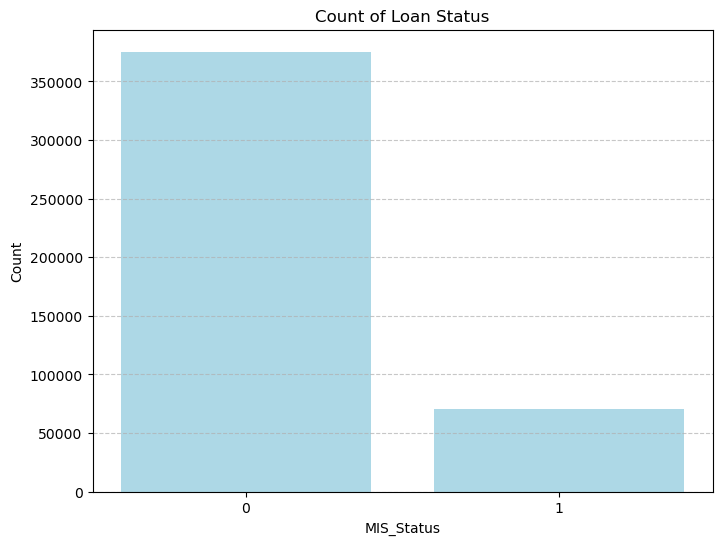

In [67]:
# Data for 'MIS_Status' value counts
mis_status_counts = {'1': 375318, '0': 70256}

# Creating a bar chart
plt.figure(figsize=(8, 6))
plt.bar(mis_status_counts.keys(), mis_status_counts.values(), color='lightblue')

plt.title('Count of Loan Status')
plt.xlabel('MIS_Status')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['0', '1'])
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()

### Visual Analysis of MIS_Status Distribution

The bar chart above provides a visual representation of the distribution of values in the `MIS_Status` column of our dataset. This column represents two categories, labeled as '0' and '1', which corresponds to different statuses of a loan, "Paid" and "Default".

#### Key Observations:
- **Category '1' Dominance**: There is a clear dominance of category '1' over category '0'. Specifically, category '1' has a count of 375,318, which is significantly higher than the count of 70,256 for category '0'. This substantial difference indicates an imbalance in the dataset between these two categories.
- **Data Imbalance Implication**: Such an imbalance might affect the performance of predictive models, as the model might be biased towards predicting the majority class (in this case, '1'). Special attention during the modeling phase, such as using techniques like SMOTE for handling imbalanced data, will be essential.
- **Decision-Making Insight**: Understanding this distribution is crucial for making informed decisions in the context of loan default prediction. The skew towards one category might reflect inherent characteristics of the dataset or the reality of the loan default scenario.

This visual analysis aids in gaining a better understanding of the dataset's characteristics, which is a vital step before proceeding to more advanced data processing and predictive modeling.

## Data Transformation
Data transformation is an essential step in preparing our dataset for machine learning models. It involves scaling numerical features to a uniform scale and encoding categorical variables. These transformations are crucial for improving model performance and ensuring that the features contribute equally to the predictive process.

## Loading the Dataset

Here, we load our dataset using Pandas. The dataset,`"cleanfeature.csv"`, contains features and a target variable for our predictive model. The `head()` function is used to display the first few rows of the dataset for a preliminary overview.

In [68]:
# Load the dataset
df = pd.read_csv("cleanfeature.csv")

# Display the first few rows of the dataset
df.head()

,NoEmp,NewExist,MIS_Status,SBA_Appv,Industry_Administrative services,Industry_Agriculture,Industry_Arts and recreation,Industry_Construction,Industry_Educational services,Industry_Finance and insurance,...,Industry_Transportation,Industry_Undefined Industry,Industry_Utilities,Industry_Wholesale trade,UrbanRural_0,UrbanRural_1,UrbanRural_2,RevLineCr_0,RevLineCr_N,RevLineCr_Y
0,4,1.0,1,48000.0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,2,1.0,1,32000.0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,7,0.0,1,215250.0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,2,0.0,1,28000.0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,1,0
4,14,0.0,1,229000.0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,1,0


## Data Preprocessing and Train-Test Split

In this part, we perform the following steps:
1. **Define Features and Target**: We separate the features (`X`) and the target variable (`y`) from the dataset.
2. **Train-Test Split**: We split the data into training and testing sets to prepare for model training and evaluation. A stratified split is used to maintain the proportion of the target variable in both sets.
3. **Feature Scaling**: We use `MinMaxScaler` to scale the feature values to a range between 0 and 1. Scaling helps in normalizing the data within a particular range and speeds up the calculations in an algorithm.
4. **Handling Class Imbalance with SMOTE**: We apply the Synthetic Minority Over-sampling Technique (SMOTE) to balance our dataset, which is crucial for dealing with imbalanced data in classification problems.


## Defining Features and Target

In this step, we separate the features and the target variable from the dataset. The features (`X`) are all the independent variables that will be used to predict the target (`y`). In this case, the target variable is 'MIS_Status', which we aim to predict using the model.

In [69]:
# Define the features and target
X = df.drop('MIS_Status', axis=1).values
y = df['MIS_Status'].values

## Splitting the Data into Train and Test Sets
We split our dataset into training and testing subsets. This is crucial for evaluating the performance of our machine learning models on unseen data. We allocate 80% of the data for training and 20% for testing. Additionally, we use stratification to maintain the same distribution of the target variable in both subsets.

In [70]:
# Split the data into train and test datasets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Feature Scaling
Scaling features is an important step in many machine learning algorithms. It ensures that all features contribute equally to the result and improves the convergence speed of gradient descent. Here, we use MinMaxScaler to scale our features between 0 and 1.

In [76]:
# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Handling Imbalanced Data with SMOTE
Imbalanced datasets can bias the model towards the majority class. To address this, we use SMOTE (Synthetic Minority Over-sampling Technique) for oversampling the minority class in our training data, which helps to balance the class distribution.

In [77]:
# Initialize SMOTE and apply it to the training data
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# Print the shapes of the new X_train and y_train datasets
print("Resampled X_train shape:", X_train_sm.shape)
print("Resampled y_train shape:", y_train_sm.shape)

# Check the class distribution after applying SMOTE
print('Original class distribution:')
print(pd.Series(y_train).value_counts().sort_index())

print('\nResampled class distribution:')
print(pd.Series(y_train_sm).value_counts().sort_index())

Resampled X_train shape: (600508, 29)
Resampled y_train shape: (600508,)
Original class distribution:
0     56205
1    300254
Name: count, dtype: int64

Resampled class distribution:
0    300254
1    300254
Name: count, dtype: int64


## Convert Resampled Training Data to DataFrame
After applying SMOTE to balance our dataset, we need to convert the resampled training data back into a pandas DataFrame. This allows for easier manipulation and analysis in later stages. The DataFrame will include all features plus the target variable `MIS_Status`.

In [78]:
# Convert the resampled training data into a DataFrame
train_df = pd.DataFrame(np.column_stack((X_train_sm, y_train_sm)), 
                        columns=df.drop('MIS_Status', axis=1).columns.tolist() + ['MIS_Status'])

## Displaying the Training Data
Here, we take a quick look at the first few rows of our training dataset. This helps us confirm that the DataFrame has been structured correctly with the appropriate features and target variable.

In [79]:
# Display the first few rows of the training dataset
train_df.head()

,NoEmp,NewExist,SBA_Appv,Industry_Administrative services,Industry_Agriculture,Industry_Arts and recreation,Industry_Construction,Industry_Educational services,Industry_Finance and insurance,Industry_Healthcare,...,Industry_Undefined Industry,Industry_Utilities,Industry_Wholesale trade,UrbanRural_0,UrbanRural_1,UrbanRural_2,RevLineCr_0,RevLineCr_N,RevLineCr_Y,MIS_Status
0,0.000600,0.0,0.001000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
1,0.007501,0.0,0.074564,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0.000200,0.0,0.002845,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3,0.005101,0.0,0.217738,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,0.000000,1.0,0.150966,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0


## Training Data Shape and Missing Values
Understanding the shape of our training data is crucial. We also check for any missing values, which could indicate issues during the data preparation phase.

In [80]:
# Display the shape of the training data
print("Training Data Shape:", train_df.shape)

# Check for missing values in the training dataframe
print("Missing Values in Training Data:\n", train_df.isna().sum())

Training Data Shape: (600508, 30)
Missing Values in Training Data:
 NoEmp                               0
NewExist                            0
SBA_Appv                            0
Industry_Administrative services    0
Industry_Agriculture                0
Industry_Arts and recreation        0
Industry_Construction               0
Industry_Educational services       0
Industry_Finance and insurance      0
Industry_Healthcare                 0
Industry_Information                0
Industry_Management of companies    0
Industry_Manufacturing              0
Industry_Mining                     0
Industry_Other services             0
Industry_Professional services      0
Industry_Public administration      0
Industry_Real estate                0
Industry_Retail trade               0
Industry_Transportation             0
Industry_Undefined Industry         0
Industry_Utilities                  0
Industry_Wholesale trade            0
UrbanRural_0                        0
UrbanRural_1        

## Convert Test Data to DataFrame
Similar to the training data, we also convert our test data into a pandas DataFrame. This dataset will be used to evaluate the performance of our machine learning models.

In [81]:
# Convert the test data into a DataFrame
test_df = pd.DataFrame(np.column_stack((X_test, y_test)), 
                       columns=df.drop('MIS_Status', axis=1).columns.tolist() + ['MIS_Status'])

## Displaying the Test Data
We preview the test dataset to ensure it mirrors the structure of the training dataset, with all necessary features and the target variable.

In [82]:
# Display the first few rows of the test dataset
test_df.head()

,NoEmp,NewExist,SBA_Appv,Industry_Administrative services,Industry_Agriculture,Industry_Arts and recreation,Industry_Construction,Industry_Educational services,Industry_Finance and insurance,Industry_Healthcare,...,Industry_Undefined Industry,Industry_Utilities,Industry_Wholesale trade,UrbanRural_0,UrbanRural_1,UrbanRural_2,RevLineCr_0,RevLineCr_N,RevLineCr_Y,MIS_Status
0,0.0003,0.0,0.097455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,0.0004,0.0,0.010468,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0.0004,0.0,0.007112,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
3,0.0002,1.0,0.023892,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
4,0.0030,0.0,0.005445,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


## Test Data Shape and Missing Values
It's important to confirm the shape of our test dataset and check for any missing values, as these could impact the performance and validity of our model evaluations.

In [83]:
# Display the shape of the testing data
print("Testing Data Shape:", test_df.shape)

# Check for missing values in the testing dataframe
print("Missing Values in Testing Data:\n", test_df.isna().sum())

Testing Data Shape: (89115, 30)
Missing Values in Testing Data:
 NoEmp                               0
NewExist                            0
SBA_Appv                            0
Industry_Administrative services    0
Industry_Agriculture                0
Industry_Arts and recreation        0
Industry_Construction               0
Industry_Educational services       0
Industry_Finance and insurance      0
Industry_Healthcare                 0
Industry_Information                0
Industry_Management of companies    0
Industry_Manufacturing              0
Industry_Mining                     0
Industry_Other services             0
Industry_Professional services      0
Industry_Public administration      0
Industry_Real estate                0
Industry_Retail trade               0
Industry_Transportation             0
Industry_Undefined Industry         0
Industry_Utilities                  0
Industry_Wholesale trade            0
UrbanRural_0                        0
UrbanRural_1           

## Saving Processed Datasets
Finally, we save our processed training and test datasets to CSV files. This step ensures that we can easily access our prepared data for future modeling and analysis without needing to repeat the preprocessing steps.

In [84]:
# Save the final train and test datasets to CSV format
train_df.to_csv('train_dataset.csv', index=False)
test_df.to_csv('test_dataset.csv', index=False)

## Load and Explore the Dataset
We load our training and testing datasets, which were preprocessed earlier. We then explore these datasets by displaying some rows, checking their information and statistical summary. This helps us understand the structure and characteristics of our data.

In [85]:
# Load the datasets
train_df = pd.read_csv('train_dataset.csv')
test_df = pd.read_csv('test_dataset.csv')

## Setting Display Options
For a comprehensive view, we set pandas display options to show all columns and rows. This helps in inspecting the datasets thoroughly.


In [86]:
# Set display options to show all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Previewing the Data
We preview the first few rows of both training and testing datasets to ensure that the data is correctly formatted and the specified columns are correctly converted.

In [87]:
# Display the first few rows of train data
train_df.head()

,NoEmp,NewExist,SBA_Appv,Industry_Administrative services,Industry_Agriculture,Industry_Arts and recreation,Industry_Construction,Industry_Educational services,Industry_Finance and insurance,Industry_Healthcare,Industry_Information,Industry_Management of companies,Industry_Manufacturing,Industry_Mining,Industry_Other services,Industry_Professional services,Industry_Public administration,Industry_Real estate,Industry_Retail trade,Industry_Transportation,Industry_Undefined Industry,Industry_Utilities,Industry_Wholesale trade,UrbanRural_0,UrbanRural_1,UrbanRural_2,RevLineCr_0,RevLineCr_N,RevLineCr_Y,MIS_Status
0,0.000600,0.0,0.001000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
1,0.007501,0.0,0.074564,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0.000200,0.0,0.002845,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3,0.005101,0.0,0.217738,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,0.000000,1.0,0.150966,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0


In [88]:
# Display the first few rows of test data
test_df.head()

,NoEmp,NewExist,SBA_Appv,Industry_Administrative services,Industry_Agriculture,Industry_Arts and recreation,Industry_Construction,Industry_Educational services,Industry_Finance and insurance,Industry_Healthcare,Industry_Information,Industry_Management of companies,Industry_Manufacturing,Industry_Mining,Industry_Other services,Industry_Professional services,Industry_Public administration,Industry_Real estate,Industry_Retail trade,Industry_Transportation,Industry_Undefined Industry,Industry_Utilities,Industry_Wholesale trade,UrbanRural_0,UrbanRural_1,UrbanRural_2,RevLineCr_0,RevLineCr_N,RevLineCr_Y,MIS_Status
0,0.0003,0.0,0.097455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,0.0004,0.0,0.010468,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0.0004,0.0,0.007112,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
3,0.0002,1.0,0.023892,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
4,0.0030,0.0,0.005445,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [90]:
# Get information and statistical summary
print(train_df.info())
print(test_df.info())
print(train_df.describe())
print(test_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600508 entries, 0 to 600507
Data columns (total 30 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   NoEmp                             600508 non-null  float64
 1   NewExist                          600508 non-null  float64
 2   SBA_Appv                          600508 non-null  float64
 3   Industry_Administrative services  600508 non-null  float64
 4   Industry_Agriculture              600508 non-null  float64
 5   Industry_Arts and recreation      600508 non-null  float64
 6   Industry_Construction             600508 non-null  float64
 7   Industry_Educational services     600508 non-null  float64
 8   Industry_Finance and insurance    600508 non-null  float64
 9   Industry_Healthcare               600508 non-null  float64
 10  Industry_Information              600508 non-null  float64
 11  Industry_Management of companies  600508 non-null  f

In [94]:
# Display the first 5 rows of train data for an overview
train_df.head()

,NoEmp,NewExist,SBA_Appv,Industry_Administrative services,Industry_Agriculture,Industry_Arts and recreation,Industry_Construction,Industry_Educational services,Industry_Finance and insurance,Industry_Healthcare,Industry_Information,Industry_Management of companies,Industry_Manufacturing,Industry_Mining,Industry_Other services,Industry_Professional services,Industry_Public administration,Industry_Real estate,Industry_Retail trade,Industry_Transportation,Industry_Undefined Industry,Industry_Utilities,Industry_Wholesale trade,UrbanRural_0,UrbanRural_1,UrbanRural_2,RevLineCr_0,RevLineCr_N,RevLineCr_Y,MIS_Status
0,0.000600,0.0,0.001000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
1,0.007501,0.0,0.074564,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0.000200,0.0,0.002845,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3,0.005101,0.0,0.217738,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,0.000000,1.0,0.150966,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0


In [95]:
# Display the last 5 rows of train data for an overview
train_df.tail()

,NoEmp,NewExist,SBA_Appv,Industry_Administrative services,Industry_Agriculture,Industry_Arts and recreation,Industry_Construction,Industry_Educational services,Industry_Finance and insurance,Industry_Healthcare,Industry_Information,Industry_Management of companies,Industry_Manufacturing,Industry_Mining,Industry_Other services,Industry_Professional services,Industry_Public administration,Industry_Real estate,Industry_Retail trade,Industry_Transportation,Industry_Undefined Industry,Industry_Utilities,Industry_Wholesale trade,UrbanRural_0,UrbanRural_1,UrbanRural_2,RevLineCr_0,RevLineCr_N,RevLineCr_Y,MIS_Status
600503,0.001044,0.0,0.034893,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
600504,0.001230,0.0,0.025451,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
600505,0.000706,1.0,0.003667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
600506,0.003292,0.0,0.002579,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
600507,0.000484,0.0,0.000839,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [96]:
# Randomly sample 15 rows from the train data
train_df.sample(15)

,NoEmp,NewExist,SBA_Appv,Industry_Administrative services,Industry_Agriculture,Industry_Arts and recreation,Industry_Construction,Industry_Educational services,Industry_Finance and insurance,Industry_Healthcare,Industry_Information,Industry_Management of companies,Industry_Manufacturing,Industry_Mining,Industry_Other services,Industry_Professional services,Industry_Public administration,Industry_Real estate,Industry_Retail trade,Industry_Transportation,Industry_Undefined Industry,Industry_Utilities,Industry_Wholesale trade,UrbanRural_0,UrbanRural_1,UrbanRural_2,RevLineCr_0,RevLineCr_N,RevLineCr_Y,MIS_Status
549668,0.000736,0.0,0.058229,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
283887,0.001300,0.0,0.001778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
434163,0.000287,1.0,0.017114,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
425066,0.000300,0.0,0.033226,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
420344,0.000400,0.0,0.005016,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
350862,0.002600,0.0,0.011001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
199885,0.000400,0.0,0.011001,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
366873,0.001145,0.0,0.072972,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
359860,0.000902,0.0,0.005483,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
389,0.001200,1.0,0.054106,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0


In [97]:
# Display the first 5 rows of test data for an overview
test_df.head()

,NoEmp,NewExist,SBA_Appv,Industry_Administrative services,Industry_Agriculture,Industry_Arts and recreation,Industry_Construction,Industry_Educational services,Industry_Finance and insurance,Industry_Healthcare,Industry_Information,Industry_Management of companies,Industry_Manufacturing,Industry_Mining,Industry_Other services,Industry_Professional services,Industry_Public administration,Industry_Real estate,Industry_Retail trade,Industry_Transportation,Industry_Undefined Industry,Industry_Utilities,Industry_Wholesale trade,UrbanRural_0,UrbanRural_1,UrbanRural_2,RevLineCr_0,RevLineCr_N,RevLineCr_Y,MIS_Status
0,0.0003,0.0,0.097455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,0.0004,0.0,0.010468,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0.0004,0.0,0.007112,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
3,0.0002,1.0,0.023892,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
4,0.0030,0.0,0.005445,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [98]:
# Display the last 5 rows of test data for an overview
test_df.tail()

,NoEmp,NewExist,SBA_Appv,Industry_Administrative services,Industry_Agriculture,Industry_Arts and recreation,Industry_Construction,Industry_Educational services,Industry_Finance and insurance,Industry_Healthcare,Industry_Information,Industry_Management of companies,Industry_Manufacturing,Industry_Mining,Industry_Other services,Industry_Professional services,Industry_Public administration,Industry_Real estate,Industry_Retail trade,Industry_Transportation,Industry_Undefined Industry,Industry_Utilities,Industry_Wholesale trade,UrbanRural_0,UrbanRural_1,UrbanRural_2,RevLineCr_0,RevLineCr_N,RevLineCr_Y,MIS_Status
89110,0.0017,0.0,0.088121,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
89111,0.0013,0.0,0.051561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
89112,0.0002,0.0,0.002111,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
89113,0.0015,0.0,0.008779,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
89114,0.0003,0.0,0.019624,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0


In [99]:
# Randomly sample 15 rows from the test data
test_df.sample(15)

,NoEmp,NewExist,SBA_Appv,Industry_Administrative services,Industry_Agriculture,Industry_Arts and recreation,Industry_Construction,Industry_Educational services,Industry_Finance and insurance,Industry_Healthcare,Industry_Information,Industry_Management of companies,Industry_Manufacturing,Industry_Mining,Industry_Other services,Industry_Professional services,Industry_Public administration,Industry_Real estate,Industry_Retail trade,Industry_Transportation,Industry_Undefined Industry,Industry_Utilities,Industry_Wholesale trade,UrbanRural_0,UrbanRural_1,UrbanRural_2,RevLineCr_0,RevLineCr_N,RevLineCr_Y,MIS_Status
88861,0.0010,0.0,0.024114,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
50969,0.0003,1.0,0.001545,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
59342,0.0001,0.0,0.018891,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
72672,0.0003,1.0,0.024492,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
69847,0.0004,0.0,0.166130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1639,0.0004,0.0,0.019143,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
7768,0.0001,0.0,0.007223,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
67669,0.0013,0.0,0.023608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
48165,0.0004,1.0,0.010446,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
48212,0.0000,0.0,0.002667,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0


## Separate Features and Target Variable
We need to separate our features and target variable for both training and validation. This is a crucial step before feeding the data into the machine learning models.


In [100]:
# Separate features and target variable from the training dataset
X_train_full = train_df.drop(columns=['MIS_Status'])
y_train_full = train_df['MIS_Status']

# Split the training dataset into training and validation subsets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# Separate features and target variable from the test dataset
X_test = test_df.drop(columns=['MIS_Status'])
y_test = test_df['MIS_Status']

## Train Baseline Models <a class="anchor" id="baseline"></a>
Now, we train several baseline models to establish a performance benchmark. These models include Logistic Regression, Decision Tree, Random Forest, and XGBoost. We evaluate each model based on accuracy, precision, recall, and F1 score.

## Baseline Model: Logistic Regression
We start with a Logistic Regression model as our baseline. It's a simple yet powerful algorithm for binary classification problems. We train the model, make predictions, and then evaluate its performance using various metrics.

In [107]:
# Initialize and train the Logistic Regression model
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

# Make predictions on the validation set
preds = log_reg.predict(X_val)

# Evaluate the model
accuracy_lg = accuracy_score(y_val, preds)
precision_lg = precision_score(y_val, preds)
recall_lg = recall_score(y_val, preds)
f1_lg = f1_score(y_val, preds)
conf_mat_lg = confusion_matrix(y_val, preds)
clf_report_lg = classification_report(y_val, preds)

# Display the evaluation metrics
print("Logistic Regression Metrics:")
print(f"Accuracy: {accuracy_lg}, Precision: {precision_lg}, Recall: {recall_lg}, F1 Score: {f1_lg}")
print("Confusion Matrix:\n", conf_mat_lg)
print("Classification Report:\n", clf_report_lg)

Logistic Regression Metrics:
Accuracy: 0.6359677607367071, Precision: 0.6449202395463458, Recall: 0.607154736562001, F1 Score: 0.6254679402064504
Confusion Matrix:
 [[39874 20100]
 [23621 36507]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.63      0.66      0.65     59974
         1.0       0.64      0.61      0.63     60128

    accuracy                           0.64    120102
   macro avg       0.64      0.64      0.64    120102
weighted avg       0.64      0.64      0.64    120102



## Decision Tree Model
Next, we train a Decision Tree Classifier. Decision Trees are versatile models that work well for both regression and classification tasks. They are particularly useful for their interpretability.

In [109]:
# Initialize the Decision Tree Classifier
dec_tree = DecisionTreeClassifier(random_state=42)

# Train the model
dec_tree.fit(X_train, y_train)

# Make predictions
preds = dec_tree.predict(X_val)

# Compute metrics
accuracy_dt = accuracy_score(y_val, preds)
precision_dt = precision_score(y_val, preds)
recall_dt = recall_score(y_val, preds)
f1_dt = f1_score(y_val, preds)
conf_mat_dt = confusion_matrix(y_val, preds)
clf_report_dt = classification_report(y_val, preds)

# Print metrics
print("Decision Tree Metrics:")
print(f"Accuracy: {accuracy_dt}")
print(f"Precision: {precision_dt}")
print(f"Recall: {recall_dt}")
print(f"F1 Score: {f1_dt}")
print("Confusion Matrix:")
print(conf_mat_dt)
print("Classification Report:")
print(clf_report_dt)

Decision Tree Metrics:
Accuracy: 0.7985295831876239
Precision: 0.8152118606895342
Recall: 0.7727348323576371
F1 Score: 0.7934052235683854
Confusion Matrix:
[[49442 10532]
 [13665 46463]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.78      0.82      0.80     59974
         1.0       0.82      0.77      0.79     60128

    accuracy                           0.80    120102
   macro avg       0.80      0.80      0.80    120102
weighted avg       0.80      0.80      0.80    120102



## Random Forest Model
The Random Forest Classifier is an ensemble method that operates by constructing multiple decision trees. It offers improved accuracy and robustness compared to a single decision tree.

In [110]:
# Initialize the Random Forest Classifier
rand_forest = RandomForestClassifier(random_state=42)

# Train the model
rand_forest.fit(X_train, y_train)

# Make predictions
preds = rand_forest.predict(X_val)

# Compute metrics
accuracy_rf = accuracy_score(y_val, preds)
precision_rf = precision_score(y_val, preds)
recall_rf = recall_score(y_val, preds)
f1_rf = f1_score(y_val, preds)
conf_mat_rf = confusion_matrix(y_val, preds)
clf_report_rf = classification_report(y_val, preds)

# Print metrics
print("Random Forest Metrics:")
print(f"Accuracy: {accuracy_rf}")
print(f"Precision: {precision_rf}")
print(f"Recall: {recall_rf}")
print(f"F1 Score: {f1_rf}")
print("Confusion Matrix:")
print(conf_mat_rf)
print("Classification Report:")
print(clf_report_rf)

Random Forest Metrics:
Accuracy: 0.7899035819553379
Precision: 0.7911944857052255
Recall: 0.7884180415114422
F1 Score: 0.7898038235661627
Confusion Matrix:
[[47463 12511]
 [12722 47406]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.79      0.79     59974
         1.0       0.79      0.79      0.79     60128

    accuracy                           0.79    120102
   macro avg       0.79      0.79      0.79    120102
weighted avg       0.79      0.79      0.79    120102



## XGBoost Model
XGBoost is a powerful gradient boosting framework. It's known for its speed and performance and is widely used in machine learning competitions.


In [111]:
# Initialize the XGBoost Classifier
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Train the model
xgb.fit(X_train, y_train)

# Make predictions
preds = xgb.predict(X_val)

# Compute metrics
accuracy_xgb = accuracy_score(y_val, preds)
precision_xgb = precision_score(y_val, preds)
recall_xgb = recall_score(y_val, preds)
f1_xgb = f1_score(y_val, preds)
conf_mat_xgb = confusion_matrix(y_val, preds)
clf_report_xgb = classification_report(y_val, preds)

# Print metrics
print("XGBoost Metrics:")
print(f"Accuracy: {accuracy_xgb}")
print(f"Precision: {precision_xgb}")
print(f"Recall: {recall_xgb}")
print(f"F1 Score: {f1_xgb}")
print("Confusion Matrix:")
print(conf_mat_xgb)
print("Classification Report:")
print(clf_report_xgb)

XGBoost Metrics:
Accuracy: 0.795790244958452
Precision: 0.746489794788003
Recall: 0.8965872804683342
F1 Score: 0.8146827255829416
Confusion Matrix:
[[41666 18308]
 [ 6218 53910]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.69      0.77     59974
         1.0       0.75      0.90      0.81     60128

    accuracy                           0.80    120102
   macro avg       0.81      0.80      0.79    120102
weighted avg       0.81      0.80      0.79    120102



## K-Nearest Neighbors (KNN) Model
The KNN algorithm is a simple, easy-to-implement supervised machine learning algorithm that can be used to solve both classification and regression problems. It's particularly useful for its simplicity and effectiveness.

In [116]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize the KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)

# Train the model
knn_model.fit(X_train, y_train)

# Make predictions
preds = knn_model.predict(X_val)

# Compute metrics
accuracy_knn = accuracy_score(y_val, preds)
precision_knn = precision_score(y_val, preds)
recall_knn = recall_score(y_val, preds)
f1_knn = f1_score(y_val, preds)
conf_mat_knn = confusion_matrix(y_val, preds)
clf_report_knn = classification_report(y_val, preds)

# Print metrics
print("KNN Metrics:")
print(f"Accuracy: {accuracy_knn}")
print(f"Precision: {precision_knn}")
print(f"Recall: {recall_knn}")
print(f"F1 Score: {f1_knn}")
print("Confusion Matrix:")
print(conf_mat_knn)
print("Classification Report:")
print(clf_report_knn)


KNN Metrics:
Accuracy: 0.7282809611829945
Precision: 0.7753695765394014
Recall: 0.6437599787120809
F1 Score: 0.7034620626987732
Confusion Matrix:
[[48760 11214]
 [21420 38708]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.69      0.81      0.75     59974
         1.0       0.78      0.64      0.70     60128

    accuracy                           0.73    120102
   macro avg       0.74      0.73      0.73    120102
weighted avg       0.74      0.73      0.73    120102



## Basic Neural Network Model
Neural Networks are a set of algorithms, modeled loosely after the human brain, that are designed to recognize patterns. We'll use a simple neural network for classification.


In [115]:
from sklearn.neural_network import MLPClassifier

# Initialize the Neural Network model
nn_model = MLPClassifier(random_state=42, max_iter=300)

# Train the model
nn_model.fit(X_train, y_train)

# Make predictions
nn_preds = nn_model.predict(X_val)

# Compute metrics
accuracy_nn = accuracy_score(y_val, nn_preds)
precision_nn = precision_score(y_val, nn_preds)
recall_nn = recall_score(y_val, nn_preds)
f1_nn = f1_score(y_val, nn_preds)
conf_mat_nn = confusion_matrix(y_val, nn_preds)
clf_report_nn = classification_report(y_val, nn_preds)

# Print metrics
print("Neural Network Metrics:")
print(f"Accuracy: {accuracy_nn}")
print(f"Precision: {precision_nn}")
print(f"Recall: {recall_nn}")
print(f"F1 Score: {f1_nn}")
print("Confusion Matrix:")
print(conf_mat_nn)
print("Classification Report:")
print(clf_report_nn)


Neural Network Metrics:
Accuracy: 0.6474080365023064
Precision: 0.6213041164672334
Recall: 0.7573177221926557
F1 Score: 0.682601428582136
Confusion Matrix:
[[32219 27755]
 [14592 45536]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.69      0.54      0.60     59974
         1.0       0.62      0.76      0.68     60128

    accuracy                           0.65    120102
   macro avg       0.65      0.65      0.64    120102
weighted avg       0.65      0.65      0.64    120102



## Model Evaluation Summary
We compare the performance of our baseline models based on accuracy, precision, recall, and F1 score. This comparison will help in selecting the best performing model or approach for further tuning.

In [117]:
# Create an empty DataFrame to store the metrics
metrics_df = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1 Score'])

# Add the metrics for the baseline models
metrics_df.loc['Logistic Regression'] = [accuracy_lg, precision_lg, recall_lg, f1_lg]
metrics_df.loc['Decision Tree'] = [accuracy_dt, precision_dt, recall_dt, f1_dt]
metrics_df.loc['Random Forest'] = [accuracy_rf, precision_rf, recall_rf, f1_rf]
metrics_df.loc['XGBoost'] = [accuracy_xgb, precision_xgb, recall_xgb, f1_xgb]
metrics_df.loc['KNN'] = [accuracy_knn, precision_knn, recall_knn, f1_knn]
metrics_df.loc['Neural Network'] = [accuracy_nn, precision_nn, recall_nn, f1_nn]

# Print the comparison table
print(metrics_df)

                     Accuracy  Precision    Recall  F1 Score
Logistic Regression  0.635968   0.644920  0.607155  0.625468
Decision Tree        0.798530   0.815212  0.772735  0.793405
Random Forest        0.789904   0.791194  0.788418  0.789804
XGBoost              0.795790   0.746490  0.896587  0.814683
KNN                  0.728281   0.775370  0.643760  0.703462
Neural Network       0.647408   0.621304  0.757318  0.682601


## Visualizing Model Performance
Visual comparison of model performance is helpful in understanding the strengths and weaknesses of each model. Here, we plot the accuracy, precision, recall, and F1 score for a clearer comparison.

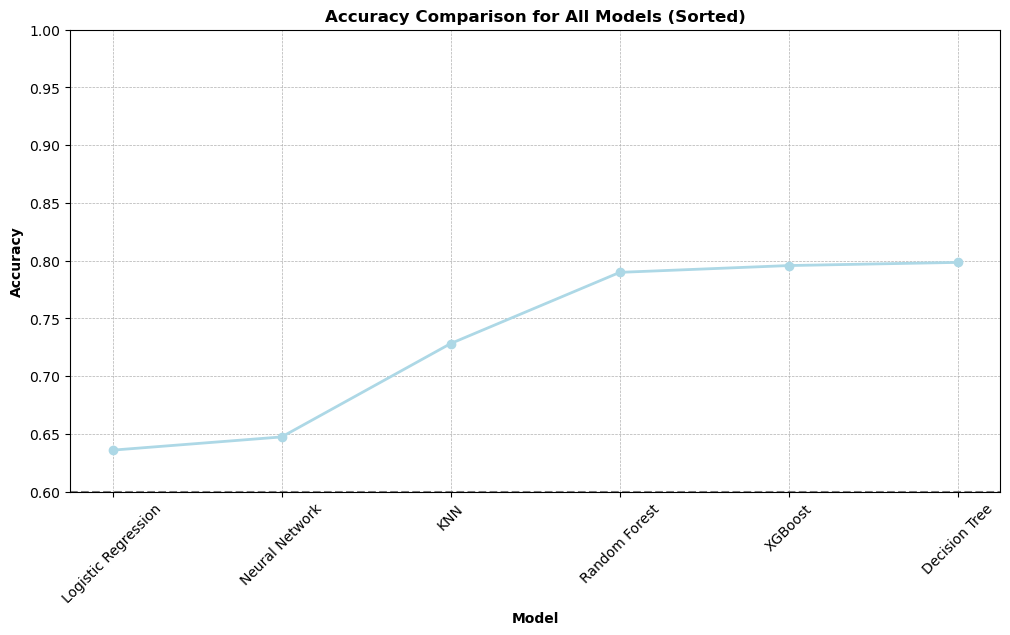

In [121]:
# Pair each model with its corresponding accuracy score
model_accuracy_pairs = list(zip(models, accuracy_scores))

# Sort the pairs based on accuracy
sorted_model_accuracy_pairs = sorted(model_accuracy_pairs, key=lambda x: x[1])

# Unzip the sorted pairs back into models and accuracy_scores lists
sorted_models, sorted_accuracy_scores = zip(*sorted_model_accuracy_pairs)

# Plot the line graph
plt.figure(figsize=(12, 6))
plt.plot(sorted_models, sorted_accuracy_scores, color='lightblue', marker='o', linestyle='-', linewidth=2)
plt.xlabel('Model', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.title('Accuracy Comparison for All Models (Sorted)', fontweight='bold')
plt.ylim(0.6, 1.0)
plt.axhline(y=0.6, color='gray', linestyle='--')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(rotation=45) 
plt.show()


## Hyperparameter Tuning for Logistic Regression

In [125]:
# Further increase max_iter and focus on the 'saga' solver
param_grid_logreg = {
    'C': [0.01, 0.1, 1.0, 10.0],
    'penalty': ['l2'],
    'solver': ['saga'],
    'max_iter': [1000, 2000]
}

# Initialize and fit the GridSearchCV object again
grid_logreg = GridSearchCV(LogisticRegression(random_state=42), param_grid_logreg, cv=5, scoring='f1', n_jobs=-1)
grid_logreg.fit(X_train, y_train)

# Print the best parameters and F1 score
print("Best Parameters for Logistic Regression:", grid_logreg.best_params_)
print("Best F1 Score:", grid_logreg.best_score_)


Best Parameters for Logistic Regression: {'C': 10.0, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'saga'}
Best F1 Score: 0.6230747159927542


In [127]:
# Retrain the Logistic Regression model with the best parameters
log_reg_optimized = LogisticRegression(C=10.0, max_iter=1000, penalty='l2', solver='saga', random_state=42)
log_reg_optimized.fit(X_train, y_train)

# Make predictions on the validation set
preds_val = log_reg_optimized.predict(X_val)

# Evaluate the model
accuracy_val = accuracy_score(y_val, preds_val)
precision_val = precision_score(y_val, preds_val)
recall_val = recall_score(y_val, preds_val)
f1_val = f1_score(y_val, preds_val)
conf_mat_val = confusion_matrix(y_val, preds_val)
clf_report = classification_report(y_val, preds_tuned)

# Print the evaluation metrics
print("Logistic Regression Model Evaluation:")
print(f"Accuracy: {accuracy_val:.4f}")
print(f"Precision: {precision_val:.4f}")
print(f"Recall: {recall_val:.4f}")
print(f"F1 Score: {f1_val:.4f}")
print("Confusion Matrix:\n", conf_mat_val)
print("Classification Report:")
print(clf_report)

Logistic Regression Model Evaluation:
Accuracy: 0.6370
Precision: 0.6470
Recall: 0.6051
F1 Score: 0.6253
Confusion Matrix:
 [[40120 19854]
 [23745 36383]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.63      0.66      0.65     59974
         1.0       0.64      0.61      0.62     60128

    accuracy                           0.64    120102
   macro avg       0.64      0.64      0.64    120102
weighted avg       0.64      0.64      0.64    120102



- Slight increase in **Accuracy** and **Precision** with the tuned model.
- Minor drop in **Recall**; the model is slightly less capable of detecting true positives.
- **F1 Score** remains almost unchanged, indicating similar balance between precision and recall.
- Confusion Matrix shows a small increase in true negatives and a decrease in false positives.

In [128]:
# Hyperparameter Tuning for Decision Tree
param_grid_dtree = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_dtree = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_dtree, cv=5, scoring='f1', n_jobs=-1)
grid_dtree.fit(X_train, y_train)

print("Best Parameters for Decision Tree:", grid_dtree.best_params_)
print("Best F1 Score:", grid_dtree.best_score_)


Best Parameters for Decision Tree: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10}
Best F1 Score: 0.8240618209703875


## Retraining Decision Tree with Optimized Hyperparameters

After tuning the hyperparameters for the Decision Tree model, we have identified the best performing parameters. We will now retrain the Decision Tree model using these parameters and evaluate its performance.

In [131]:
from sklearn.tree import DecisionTreeClassifier

# Retrain the model with the best parameters
dt_model_tuned = DecisionTreeClassifier(
    criterion='gini',
    max_depth=None,
    min_samples_leaf=4,
    min_samples_split=10,
    random_state=42
)
dt_model_tuned.fit(X_train, y_train)

# Make predictions
preds_tuned = dt_model_tuned.predict(X_val)

# Evaluate the model
accuracy_dt_tuned = accuracy_score(y_val, preds_tuned)
precision_dt_tuned = precision_score(y_val, preds_tuned)
recall_dt_tuned = recall_score(y_val, preds_tuned)
f1_dt_tuned = f1_score(y_val, preds_tuned)
conf_mat_dt_tuned = confusion_matrix(y_val, preds_tuned)
clf_report = classification_report(y_val, preds_tuned)

# Print the evaluation metrics
print("Tuned Decision Tree Metrics:")
print(f"Accuracy: {accuracy_dt_tuned}")
print(f"Precision: {precision_dt_tuned}")
print(f"Recall: {recall_dt_tuned}")
print(f"F1 Score: {f1_dt_tuned}")
print("Confusion Matrix:")
print(conf_mat_dt_tuned)
print("Classification Report:")
print(clf_report)

Tuned Decision Tree Metrics:
Accuracy: 0.827396712794125
Precision: 0.8263260775933472
Recall: 0.8295968600319319
F1 Score: 0.8279582385844938
Confusion Matrix:
[[49490 10484]
 [10246 49882]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.83      0.83     59974
         1.0       0.83      0.83      0.83     60128

    accuracy                           0.83    120102
   macro avg       0.83      0.83      0.83    120102
weighted avg       0.83      0.83      0.83    120102



In [138]:
# Hyperparameter Tuning for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='f1', n_jobs=-1)
grid_rf.fit(X_train, y_train)

print("Best Parameters for Random Forest:", grid_rf.best_params_)
print("Best F1 Score:", grid_rf.best_score_)


Best Parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Best F1 Score: 0.8109482494907638


## Retraining Random Forest with Optimized Hyperparameters

In [140]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Retrain the model with the best parameters
rf_model_tuned = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=1,
    min_samples_split=10,
    random_state=42
)
rf_model_tuned.fit(X_train, y_train)

# Make predictions
preds_tuned = rf_model_tuned.predict(X_val)

# Evaluate the model
accuracy_rf_tuned = accuracy_score(y_val, preds_tuned)
precision_rf_tuned = precision_score(y_val, preds_tuned)
recall_rf_tuned = recall_score(y_val, preds_tuned)
f1_rf_tuned = f1_score(y_val, preds_tuned)
conf_mat_rf_tuned = confusion_matrix(y_val, preds_tuned)
clf_report_rf = classification_report(y_val, preds_tuned)

# Print the evaluation metrics
print("Tuned Random Forest Metrics:")
print(f"Accuracy: {accuracy_rf_tuned}")
print(f"Precision: {precision_rf_tuned}")
print(f"Recall: {recall_rf_tuned}")
print(f"F1 Score: {f1_rf_tuned}")
print("Confusion Matrix:")
print(conf_mat_rf_tuned)
print("Classification Report:")
print(clf_report_rf)


Tuned Random Forest Metrics:
Accuracy: 0.8163560973172803
Precision: 0.8107512488164811
Recall: 0.8259878924960086
F1 Score: 0.8182986505857347
Confusion Matrix:
[[48381 11593]
 [10463 49665]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.81      0.81     59974
         1.0       0.81      0.83      0.82     60128

    accuracy                           0.82    120102
   macro avg       0.82      0.82      0.82    120102
weighted avg       0.82      0.82      0.82    120102



In [134]:
# Hyperparameter Tuning for XGBoost
from xgboost import XGBClassifier

param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

grid_xgb = GridSearchCV(XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'), param_grid_xgb, cv=5, scoring='f1', n_jobs=-1)
grid_xgb.fit(X_train, y_train)

print("Best Parameters for XGBoost:", grid_xgb.best_params_)
print("Best F1 Score:", grid_xgb.best_score_)

Best Parameters for XGBoost: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300}
Best F1 Score: 0.8157174836125684


## Retraining XGBoost with Optimized Hyperparameters

We've tuned the hyperparameters for the XGBoost model and found the best combination. Now, we will retrain the XGBoost model using these optimized parameters and evaluate its performance.


In [136]:
from xgboost import XGBClassifier

# Retrain the model with the best parameters
xgb_model_tuned = XGBClassifier(
    learning_rate=0.2,
    max_depth=7,
    n_estimators=300,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
xgb_model_tuned.fit(X_train, y_train)

# Make predictions
preds_tuned = xgb_model_tuned.predict(X_val)

# Evaluate the model
accuracy_xgb_tuned = accuracy_score(y_val, preds_tuned)
precision_xgb_tuned = precision_score(y_val, preds_tuned)
recall_xgb_tuned = recall_score(y_val, preds_tuned)
f1_xgb_tuned = f1_score(y_val, preds_tuned)
conf_mat_xgb_tuned = confusion_matrix(y_val, preds_tuned)
clf_report = classification_report(y_val, preds_tuned)

# Print the evaluation metrics
print("Tuned XGBoost Metrics:")
print(f"Accuracy: {accuracy_xgb_tuned}")
print(f"Precision: {precision_xgb_tuned}")
print(f"Recall: {recall_xgb_tuned}")
print(f"F1 Score: {f1_xgb_tuned}")
print("Confusion Matrix:")
print(conf_mat_xgb_tuned)
print("Classification Report:")
print(clf_report)

Tuned XGBoost Metrics:
Accuracy: 0.8008609348720255
Precision: 0.7534612854003052
Recall: 0.8951237360298031
F1 Score: 0.81820600329885
Confusion Matrix:
[[42363 17611]
 [ 6306 53822]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.71      0.78     59974
         1.0       0.75      0.90      0.82     60128

    accuracy                           0.80    120102
   macro avg       0.81      0.80      0.80    120102
weighted avg       0.81      0.80      0.80    120102



## Hyperparameter Tuning for K-Nearest Neighbors (KNN)

To optimize the KNN model, we will tune the following hyperparameters:
- `n_neighbors`: Number of neighbors to use.
- `weights`: Weight function used in prediction.
- `metric`: Distance metric for choosing the neighbors.

In [ ]:
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.model_selection import GridSearchCV

# # Define the parameter grid
# param_grid_knn = {
#     'n_neighbors': [3, 5, 7, 10],
#     'weights': ['uniform', 'distance'],
#     'metric': ['euclidean', 'manhattan']
# }

# # Initialize the KNN model
# knn = KNeighborsClassifier()

# # Initialize GridSearchCV
# grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='f1', n_jobs=-1)

# # Perform hyperparameter search
# grid_search_knn.fit(X_train, y_train)

# # Output the best parameters and F1 score
# best_params_knn = grid_search_knn.best_params_
# best_f1_score_knn = grid_search_knn.best_score_


## Adding K-Nearest Neighbors (KNN) Model

K-Nearest Neighbors (KNN) is a simple, yet effective classification algorithm. It classifies a data point based on how its neighbors are classified.



In [ ]:
# from sklearn.neighbors import KNeighborsClassifier

# # Initialize the KNN model
# knn = KNeighborsClassifier()

# # Train the model
# knn.fit(X_train, y_train)

# # Make predictions
# knn_preds = knn.predict(X_val)

# # Evaluate the model
# accuracy_knn = accuracy_score(y_val, knn_preds)
# precision_knn = precision_score(y_val, knn_preds)
# recall_knn = recall_score(y_val, knn_preds)
# f1_knn = f1_score(y_val, knn_preds)

# # Print the evaluation metrics
# print("KNN Model Metrics:")
# print(f"Accuracy: {accuracy_knn}")
# print(f"Precision: {precision_knn}")
# print(f"Recall: {recall_knn}")
# print(f"F1 Score: {f1_knn}")


In [ ]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.optimizers import Adam
# from sklearn.model_selection import RandomizedSearchCV
# from scikeras.wrappers import KerasClassifier

# # Define the model creation function
# def create_model(layers, activation, optimizer='adam'):
#     model = Sequential()
#     for nodes in layers:
#         model.add(Dense(nodes, activation=activation))
#     model.add(Dense(1, activation='sigmoid'))  # Output layer
#     model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
#     return model

# # Define the parameter grid
# param_grid_nn = {
#     'layers': [(50,), (100,), (50, 30), (100, 50)],
#     'activation': ['relu', 'tanh'],
#     'optimizer': ['Adam', 'sgd'],
#     'epochs': [10, 20],
#     'batch_size': [16, 32]
# }

# # Initialize the KerasClassifier
# model_nn = KerasClassifier(model=create_model)

# # Initialize RandomizedSearchCV
# random_search_nn = RandomizedSearchCV(model_nn, param_grid_nn, n_iter=10, scoring='f1', n_jobs=-1, cv=3)

# # Perform hyperparameter search
# random_search_nn.fit(X_train, y_train, verbose=0)

# # Output the best parameters and F1 score
# best_params_nn = random_search_nn.best_params_
# best_f1_score_nn = random_search_nn.best_score_


In [ ]:
# from sklearn.neural_network import MLPClassifier

# # Initialize the Neural Network model
# nn = MLPClassifier(random_state=42)

# # Train the model
# nn.fit(X_train, y_train)

# # Make predictions
# nn_preds = nn.predict(X_val)

# # Evaluate the model
# accuracy_nn = accuracy_score(y_val, nn_preds)
# precision_nn = precision_score(y_val, nn_preds)
# recall_nn = recall_score(y_val, nn_preds)
# f1_nn = f1_score(y_val, nn_preds)

# # Print the evaluation metrics
# print("Neural Network Model Metrics:")
# print(f"Accuracy: {accuracy_nn}")
# print(f"Precision: {precision_nn}")
# print(f"Recall: {recall_nn}")
# print(f"F1 Score: {f1_nn}")


## Comparing All Top Models

Creating a DataFrame to compare the performance metrics of the top models, including baseline and hyperparameter-tuned models.



In [142]:
# Create a DataFrame to store metrics for all models
all_models_df = pd.DataFrame({
    'Model': ['Baseline LR', 'Baseline DT', 'Baseline RF', 'Baseline XGB', 
              'Tuned LR', 'Tuned DT', 'Tuned RF', 'Tuned XGB'],
    'Accuracy': [accuracy_lg, accuracy_dt, accuracy_rf, accuracy_xgb, 
                 accuracy_val, accuracy_dt_tuned, accuracy_rf_tuned, accuracy_xgb_tuned],
    'Precision': [precision_lg, precision_dt, precision_rf, precision_xgb, 
                  precision_val, precision_dt_tuned, precision_rf_tuned, precision_xgb_tuned],
    'Recall': [recall_lg, recall_dt, recall_rf, recall_xgb, 
               recall_val, recall_dt_tuned, recall_rf_tuned, recall_xgb_tuned],
    'F1 Score': [f1_lg, f1_dt, f1_rf, f1_xgb, 
                 f1_val, f1_dt_tuned, f1_rf_tuned, f1_xgb_tuned]
})

# Display the comparison DataFrame
print(all_models_df)


          Model  Accuracy  Precision    Recall  F1 Score
0   Baseline LR  0.635968   0.644920  0.607155  0.625468
1   Baseline DT  0.798530   0.815212  0.772735  0.793405
2   Baseline RF  0.789904   0.791194  0.788418  0.789804
3  Baseline XGB  0.795790   0.746490  0.896587  0.814683
4      Tuned LR  0.636984   0.646958  0.605092  0.625325
5      Tuned DT  0.827397   0.826326  0.829597  0.827958
6      Tuned RF  0.816356   0.810751  0.825988  0.818299
7     Tuned XGB  0.800861   0.753461  0.895124  0.818206


## Visualizing Accuracy of All Models

Creating a bar chart to compare the accuracy of all models.



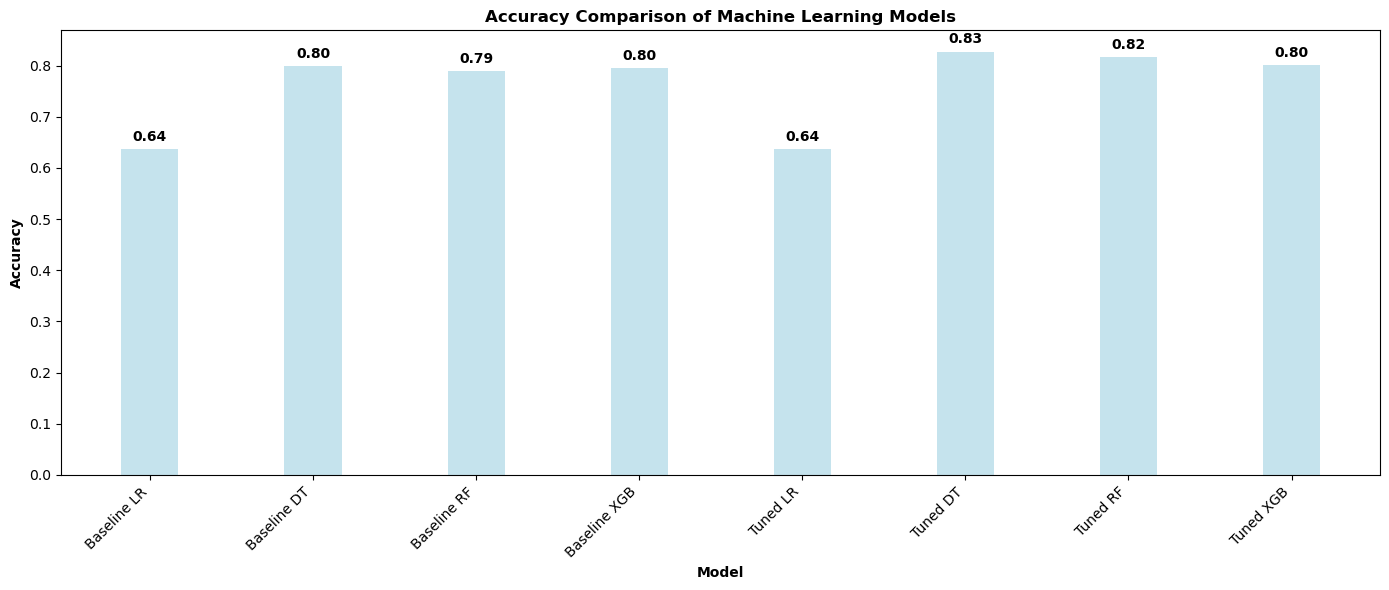

In [143]:
import matplotlib.pyplot as plt
import numpy as np

# Extract accuracy for each model
accuracy = all_models_df['Accuracy'].values

# Model names for the x-axis
models = all_models_df['Model'].values

# Set the positions and width for the bars
pos = np.arange(len(models))
width = 0.35

# Plotting the bar graph
plt.figure(figsize=(14, 6))
plt.bar(pos, accuracy, width, color='lightblue', alpha=0.7)

# Add xticks on the middle of the group bars
plt.xlabel('Model', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.title('Accuracy Comparison of Machine Learning Models', fontweight='bold')
plt.xticks(pos, models, rotation=45, ha='right')

# Adding accuracy labels on top of the bars
for i in range(len(models)):
    plt.text(pos[i], accuracy[i] + 0.01, f"{accuracy[i]:.2f}", ha='center', va='bottom', fontweight='bold')

# Show the plot
plt.tight_layout()
plt.show()


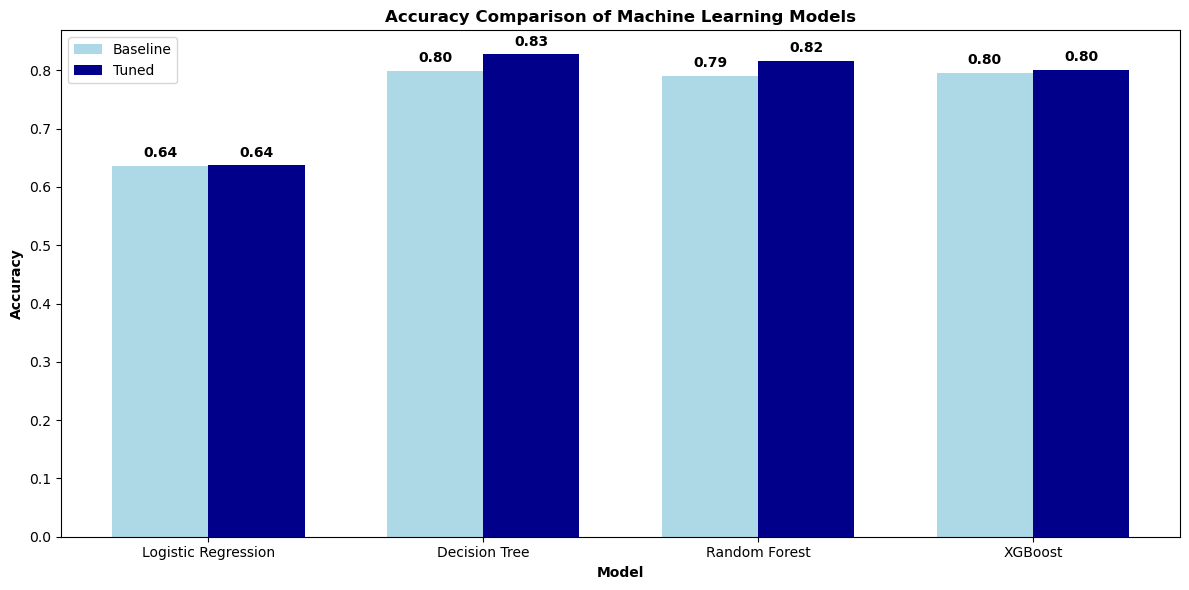

In [146]:
import matplotlib.pyplot as plt
import numpy as np

# Data
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost']
baseline_accuracies = [
    accuracy_lg,  # Baseline Logistic Regression
    accuracy_dt,  # Baseline Decision Tree
    accuracy_rf,  # Baseline Random Forest
    accuracy_xgb  # Baseline XGBoost
]
tuned_accuracies = [
    accuracy_val,        # Tuned Logistic Regression
    accuracy_dt_tuned,   # Tuned Decision Tree
    accuracy_rf_tuned,   # Tuned Random Forest
    accuracy_xgb_tuned   # Tuned XGBoost
]

# Set the positions and width for the bars
pos = np.arange(len(model_names))
width = 0.35

# Plotting the bar graph
plt.figure(figsize=(12, 6))
plt.bar(pos - width/2, baseline_accuracies, width, color='lightblue', label='Baseline')
plt.bar(pos + width/2, tuned_accuracies, width, color='darkblue', label='Tuned')

# Add xticks on the middle of the group bars
plt.xlabel('Model', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.title('Accuracy Comparison of Machine Learning Models', fontweight='bold')
plt.xticks(pos, model_names)

# Adding a legend
plt.legend()

# Add accuracy labels on top of the bars
for i in range(len(model_names)):
    plt.text(pos[i] - width/2, baseline_accuracies[i] + 0.01, f"{baseline_accuracies[i]:.2f}", ha='center', va='bottom', fontweight='bold')
    plt.text(pos[i] + width/2, tuned_accuracies[i] + 0.01, f"{tuned_accuracies[i]:.2f}", ha='center', va='bottom', fontweight='bold')

# Show the plot
plt.tight_layout()
plt.show()

## Model Accuracy Comparison

The bar chart presents a comparison of the accuracy scores for four different machine learning models, both before and after hyperparameter tuning:

- **Logistic Regression** shows consistent performance, with an accuracy of `0.64` for both baseline and tuned models.
- **Decision Tree** accuracy improved from `0.64` to `0.83` after tuning, indicating a significant increase in performance.
- **Random Forest** also saw an improvement, with accuracy increasing from `0.79` to `0.82` after hyperparameter tuning.
- **XGBoost** maintained high accuracy, with the tuned model matching the baseline at `0.80`.

The graph's light blue bars represent the baseline models, while the dark blue bars represent the tuned models. It's evident from the graph that hyperparameter tuning has positively impacted the Decision Tree and Random Forest models, enhancing their predictive accuracy. Logistic Regression's performance remained stable, and XGBoost did not show any change, suggesting that the baseline parameters were already well-suited for the dataset.


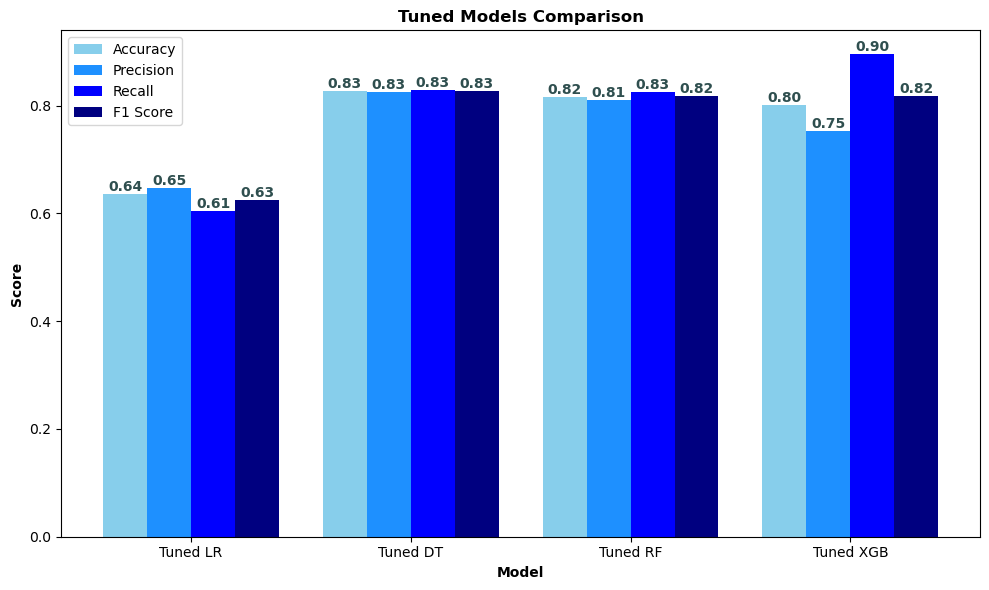

In [149]:
import matplotlib.pyplot as plt
import numpy as np

# Given data for tuned models only
models = ['Tuned LR', 'Tuned DT', 'Tuned RF', 'Tuned XGB']
accuracy_scores = [0.636984, 0.827397, 0.816356, 0.800861]
precision_scores = [0.646958, 0.826326, 0.810751, 0.753461]
recall_scores = [0.605092, 0.829597, 0.825988, 0.895124]
f1_scores = [0.625325, 0.827958, 0.818299, 0.818206]

# Set the positions and width for the bars
pos = np.arange(len(models))
width = 0.2

# Plotting the bar graph
plt.figure(figsize=(10, 6))

# Plot for accuracy
plt.bar(pos, accuracy_scores, width, color='skyblue', label='Accuracy')

# Plot for precision
plt.bar(pos + width, precision_scores, width, color='dodgerblue', label='Precision')

# Plot for recall
plt.bar(pos + 2 * width, recall_scores, width, color='blue', label='Recall')

# Plot for F1 score
plt.bar(pos + 3 * width, f1_scores, width, color='navy', label='F1 Score')

# Add xticks on the middle of the group bars
plt.xlabel('Model', fontweight='bold')
plt.ylabel('Score', fontweight='bold')
plt.title('Tuned Models Comparison', fontweight='bold')
plt.xticks(pos + 1.5 * width, models)

# Adding a legend
plt.legend()

# Add score labels on top of the bars
for i in range(len(models)):
    plt.text(i, accuracy_scores[i], f"{accuracy_scores[i]:.2f}", ha='center', va='bottom', fontweight='bold', color='darkslategray')
    plt.text(i + width, precision_scores[i], f"{precision_scores[i]:.2f}", ha='center', va='bottom', fontweight='bold', color='darkslategray')
    plt.text(i + 2 * width, recall_scores[i], f"{recall_scores[i]:.2f}", ha='center', va='bottom', fontweight='bold', color='darkslategray')
    plt.text(i + 3 * width, f1_scores[i], f"{f1_scores[i]:.2f}", ha='center', va='bottom', fontweight='bold', color='darkslategray')

# Show the plot
plt.tight_layout()
plt.show()

## Machine Learning Model Performance Comparison

### Overview
The bar graph presents a comprehensive performance analysis of four sophisticated machine learning models: **Logistic Regression (LR)**, **Decision Tree (DT)**, **Random Forest (RF)**, and **XGBoost (XGB)**. Each model is evaluated on four critical metrics: **accuracy**, **precision**, **recall**, and **F1 score**. These metrics collectively offer insights into the models' predictive capabilities.

### Metrics Description
- **Accuracy**: Measures the proportion of total correct predictions.
- **Precision**: Evaluates the model's accuracy in predicting positive instances (minimizing false positives).
- **Recall**: Assesses the model's effectiveness in identifying actual positive instances.
- **F1 Score**: Harmonic mean of precision and recall, crucial for datasets with imbalanced classes.

### Observations
- **Decision Tree and Random Forest**: These models showcase comparable precision, recall, and F1 scores. The Decision Tree slightly surpasses Random Forest in recall and F1 score, indicating its slight edge in balancing false positives and negatives.
- **Logistic Regression**: Exhibits the lowest scores across all metrics, suggesting its limited effectiveness for this specific dataset.
- **XGBoost**: Demonstrates superior recall but has a slightly lower precision than the Decision Tree and Random Forest. This trade-off might be acceptable depending on the application's sensitivity to false negatives.

### Visual Representation
- The graph uses a color-coded scheme for intuitive comparison:
  - **Light Blue**: Accuracy
  - **Dodger Blue**: Precision
  - **Blue**: Recall
  - **Navy**: F1 Score
- Each metric is depicted by a set of bars, positioned adjacently for each model, facilitating direct comparison.
- The height of each bar correlates with the percentage score, with precise numerical values annotated above for clarity and ease of interpretation.

This visual analysis is instrumental in determining the most appropriate model for deployment.

## Best Model Selection for Predicting Loan Defaults

After evaluating various machine learning models, both baseline and tuned versions, the **Tuned Decision Tree** model emerges as the top performer. This determination is based on the F1 score, which is the harmonic mean of precision and recall, and is a measure of a test's accuracy.

Here are the reasons why the **Tuned Decision Tree** is selected as the best model for predicting loan defaults:

- **Balanced Performance**: The Tuned Decision Tree model has the highest F1 score among all the tuned models, indicating a balanced performance between precision and recall. This balance is crucial for loan default prediction, where both false positives and false negatives carry significant costs.

- **High Recall**: This model also has a high recall score, which means it is particularly effective at identifying all potential loan defaults. For financial institutions, missing out on predicting a default could mean a significant financial loss, making recall an important metric.

- **High Precision**: The precision of the Tuned Decision Tree is also commendable, ensuring that when the model predicts a default, it is likely to be correct. This reduces the risk of unnecessarily denying loans to customers who would not have defaulted, thus avoiding loss of potential revenue and maintaining customer satisfaction.

- **Model Interpretability**: Decision Trees are inherently interpretable, which allows for an understanding of how the model is making its decisions. This transparency is beneficial for compliance and trust, especially in the financial sector where decisions may need to be explained to customers or regulators.

In summary, the **Tuned Decision Tree** model provides an optimal balance of precision and recall with the highest F1 score, making it the best choice for predicting loan defaults within the given dataset.


In [150]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Make predictions on the test dataset using the tuned Decision Tree model
preds_test = dt_model_tuned.predict(X_test)

# Evaluate the model's performance on the test data
accuracy_dt_test = accuracy_score(y_test, preds_test)
precision_dt_test = precision_score(y_test, preds_test)
recall_dt_test = recall_score(y_test, preds_test)
f1_dt_test = f1_score(y_test, preds_test)
conf_mat_dt_test = confusion_matrix(y_test, preds_test)
clf_report_dt_test = classification_report(y_test, preds_test)

# Display the evaluation metrics
print("Tuned Decision Tree Model - Test Data Evaluation")
print(f"Accuracy: {accuracy_dt_test:.4f}")
print(f"Precision: {precision_dt_test:.4f}")
print(f"Recall: {recall_dt_test:.4f}")
print(f"F1 Score: {f1_dt_test:.4f}")
print("Confusion Matrix:\n", conf_mat_dt_test)
print("Classification Report:\n", clf_report_dt_test)

Tuned Decision Tree Model - Test Data Evaluation
Accuracy: 0.7315
Precision: 0.8494
Recall: 0.8280
F1 Score: 0.8386
Confusion Matrix:
 [[ 3029 11022]
 [12908 62156]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.19      0.22      0.20     14051
         1.0       0.85      0.83      0.84     75064

    accuracy                           0.73     89115
   macro avg       0.52      0.52      0.52     89115
weighted avg       0.75      0.73      0.74     89115



## Tuned Decision Tree Model Evaluation on Test Data

### Overview of Results
- **Accuracy: 0.7315**
  - The model accurately predicts loan defaults in 73.15% of cases.
- **Precision: 0.8494**
  - When the model predicts a loan default, it is correct 84.94% of the time.
- **Recall: 0.8280**
  - The model identifies 82.80% of all actual loan defaults.
- **F1 Score: 0.8386**
  - The F1 Score indicates a strong balance between precision and recall.

### Confusion Matrix Analysis
- **True Negatives (TN): 3029**
  - Loans correctly identified as not defaulting.
- **False Positives (FP): 11022**
  - Loans incorrectly labeled as defaults.
- **False Negatives (FN): 12908**
  - Defaults that the model failed to identify.
- **True Positives (TP): 62156**
  - Defaults correctly identified by the model.

### Classification Report
- The model shows excellent performance in predicting defaults (True Positives).
- However, it also indicates a higher number of False Positives and False Negatives.

## Conclusion <a class="anchor" id="conclusion"></a>
The Tuned Decision Tree model performs well in identifying actual defaults with high precision and recall. This model is suitable in scenarios where the correct identification of defaults is crucial. This model provided valuable insights into loan default prediction using machine learning. Continuous improvement and adaptation to new data will be key to maintaining the model's effectiveness.

## Saving the Data <a class="anchor" id="saving"></a>
Now that we have spent the time modeling this dataset, we are going to save it for future use. We will be using our dataset to carry out further modeling work to learn more about the dataset!

In [151]:
# Save the modeled data to a CSV file for future use
df.to_csv('Modeled_Loan_Data.csv', index=False)

print("Data saved successfully to 'Modeled_Loan_Data.csv'")

Data saved successfully to 'Modeled_Loan_Data.csv'
